In [2]:
# this is copied from tile.c and made a Python list
from nle.tiles import GlyphMapper
gm = GlyphMapper()

In [43]:
import IPython.display
import PIL.Image

def display(x):
    IPython.display.display(PIL.Image.fromarray(x))
    
def save(x, dirname, name):
    t = PIL.Image.fromarray(x)
    t.save(f"/Users/samvelyan/workspace/screens/{dirname}/{name}.png")
    
display(gm.glyph_id_to_rgb(270)) # oracle
display(gm.glyph_id_to_rgb(1)) # killer bee 

In [4]:
# More reliable test
# Creating custom MiniHack task with many objects

from nle.minihack import MiniHackSkill, LevelGenerator, MiniHack

class MiniHackGUITest(MiniHackSkill):
    """Environment for "eat" task."""

    def __init__(self, *args, obs_crop_h=5, obs_crop_w=5, **kwargs):
        lvl_gen = LevelGenerator(w=5, h=5, lit=True)
        lvl_gen.add_stair_up((2, 2))

        lvl_gen.add_object("apple", "%", place=(0, 0))
        lvl_gen.add_object("pear", "%", place=(0, 1))
        lvl_gen.add_object("dagger", ")", place=(0, 2))
        lvl_gen.add_object("robe", "[", place=(0, 3))
        lvl_gen.add_object("boulder", "`", place=(0, 4))

        lvl_gen.add_terrain((1, 0), "W")  # water
        lvl_gen.add_terrain((1, 1), "L")  # lava
        lvl_gen.add_terrain((1, 2), "T")  # tree
        lvl_gen.add_terrain((1, 3), "{")  # fountain
        lvl_gen.add_terrain((1, 4), "F")  # iron bars

        lvl_gen.add_terrain((4, 0), "|")
        lvl_gen.add_terrain((4, 1), "|")
        lvl_gen.add_terrain((4, 2), "|")
        lvl_gen.add_terrain((4, 3), "|")
        lvl_gen.add_terrain((4, 4), "|")
        lvl_gen.add_door("open", place=(4, 1))
        lvl_gen.add_door("closed", place=(4, 3))

        lvl_gen.add_monster("killer bee", place=(3, 0))
        lvl_gen.add_monster("oracle", place=(3, 1))
        lvl_gen.add_monster("famine", place=(3, 2))
        lvl_gen.add_monster("giant ant", place=(3, 3))
        lvl_gen.add_monster("black dragon", place=(3, 4))

        des_file = lvl_gen.get_des()
        print(des_file)

        kwargs["observation_keys"] = (
            "glyphs_crop",
            "screen_descriptions_crop",
            "pixel_crop",
            "pixel",
            "inv_strs",
        )

        super().__init__(*args, des_file=des_file, **kwargs)


In [5]:
class MiniHackScratch(MiniHackSkill):
    def __init__(self, *args, **kwargs):
        des_file = """
MAZE: "mylevel", ' '
FLAGS:hardfloor, premapped
MESSAGE: "Welcome to MiniHack!"
INIT_MAP: solidfill,' '
GEOMETRY:center,center
MAP
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
ENDMAP
REGION:(0,0,10,10),lit,"ordinary"
$rivers = TERRAIN:{'L','W','I'}
SHUFFLE:$rivers
LOOP [2] {
  TERRAIN:randline (0,0),(10,10),5,$rivers[0]
  MONSTER:random,random
}
REPLACE_TERRAIN:(0,0,10,10),'.','T',5%
STAIR:random,down
"""
        super().__init__(*args, des_file=des_file, **kwargs)

In [31]:
def vis10(x):
    x = x[7*16:17*16,34*16:44*16,:]
    display(x)
    return x

    
def vis15(x):
    m = 4
    n= 31
    x = x[m*16:(m+15)*16,n*16:(n+15)*16,:]
    display(x)
    return x

def vis_des(des_name):
    class COR(MiniHackSkill):
        def __init__(self, *args, **kwargs):
            kwargs["wizard"] = True
            super().__init__(*args, des_file=des_name, **kwargs)

    observation_keys = ("glyphs", "pixel")
    env = COR(savedir=None,archivefile=None,observation_keys=observation_keys)
    obs = env.reset()

    for c in "#wizintrinsic\rt\r\r":
        obs,sds = env.env.step(ord(c))

    obs,_,_,_ =env.step(0)

    display(obs["pixel"]) #

In [7]:
from nle.minihack.envs.hidenseek import MiniHackHideAndSeek
from nle.minihack.envs.corridor import *

from nle.minihack.envs.mazewalk import *
observation_keys = (
     "pixel_crop",
     "pixel",
)

class mzw(MiniHackMazeWalk):
    def __init__(self, *args, **kwargs):
        kwargs["max_episode_steps"] = kwargs.pop("max_episode_steps", 200)
        super().__init__(*args, w=11, h=11, premapped=True, **kwargs)

# for i in range(10):
#     env = MiniHackMazeWalk15x15Premapped(savedir=None,archivefile=None,observation_keys=observation_keys)
#     obs = env.reset()
#     x = vis15(obs["pixel"])
#     save(x, f"mzwk_{i}")

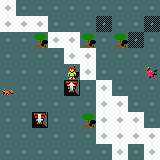

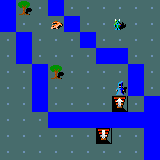

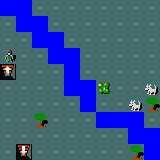

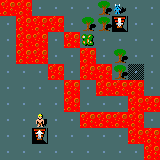

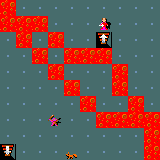

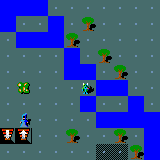

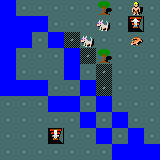

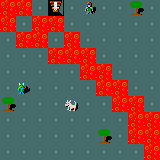

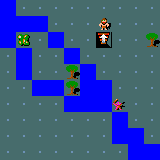

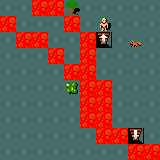

In [8]:
for i in range(10):
    env = MiniHackScratch(savedir=None,archivefile=None,observation_keys=observation_keys,wizard=True)
    obs = env.reset()
    for c in "#wizintrinsic\rt\r\r":
        obs,sds = env.env.step(ord(c))

    obs,_,_,_ =env.step(0)
    
    x = vis10(obs["pixel"],)
    save(x, "bb_{}".format(i))

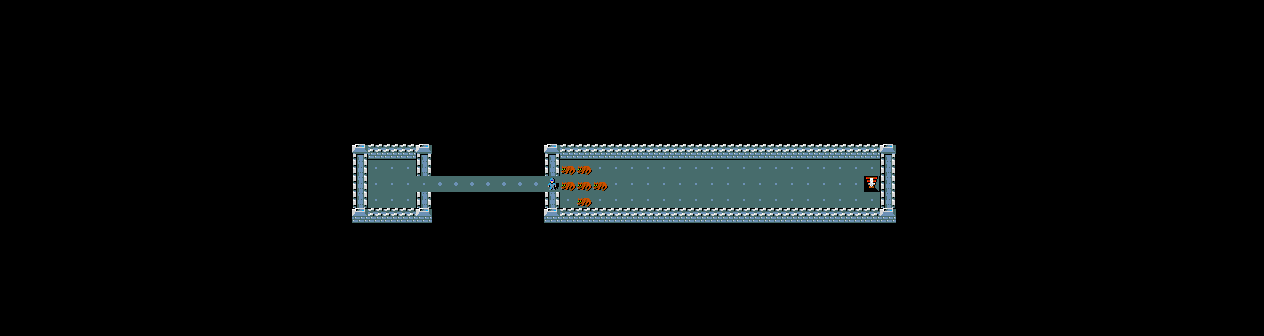

In [9]:
class MiniHackFightCorridor(MiniHackNavigation):
    def __init__(self, *args, lit=True, **kwargs):
        kwargs["character"] = "kni-hum-law-fem"  # tested on human knight
        kwargs["max_episode_steps"] = kwargs.pop("max_episode_steps", 350)

        map = """
-----       ----------------------
|...|       |....................|
|....#######.....................|
|...|       |....................|
-----       ----------------------
"""
        lvl_gen = LevelGenerator(map=map, lit=lit, flags=('premapped',))
        lvl_gen.set_start_pos((12, 2))
        lvl_gen.add_monster(name="giant rat", place=(14, 1))
        lvl_gen.add_monster(name="giant rat", place=(14, 2))
        lvl_gen.add_monster(name="giant rat", place=(14, 3))
        lvl_gen.add_monster(name="giant rat", place=(14, 1))
        lvl_gen.add_monster(name="giant rat", place=(14, 2))
        lvl_gen.add_monster(name="giant rat", place=(14, 3))
        lvl_gen.add_goal_pos((32, 2))

        super().__init__(*args, des_file=lvl_gen.get_des(), **kwargs)

env = MiniHackFightCorridor(savedir=None,archivefile=None,observation_keys=observation_keys)
obs = env.reset()
display(obs["pixel"],)

In [10]:
des_explore="""
MAZE: "mylevel", ' '
FLAGS:hardfloor
MESSAGE: "Welcome to MiniHack!"
INIT_MAP: solidfill,' '
GEOMETRY:center,center
MAP
...........
...........
...........
...........
...........
...........
...........
...........
...........
ENDMAP
$place = { (10,8),(0,8),(10,0) }
SHUFFLE: $place
REGION:(0,0,11,9),lit,"ordinary"
REPLACE_TERRAIN:(0,0,11,9), '.', 'C', 33%
REPLACE_TERRAIN:(0,0,11,9), '.', 'T', 25%
TERRAIN:randline (0,9),(11,0), 5, '.'
TERRAIN:randline (0,0),(11,9), 5, '.'
$monster = monster: { 'L','N','H','O','D','T' }
SHUFFLE: $monster
MONSTER: $monster[0], $place[0], hostile
BRANCH:(0,0,0,0),(1,1,1,1)
STAIR:$place[2],down
"""


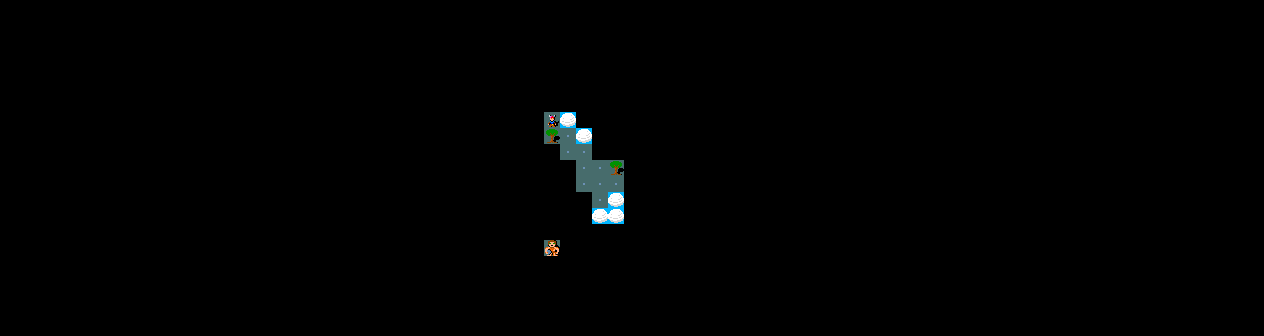

In [11]:
vis_des(des_explore)

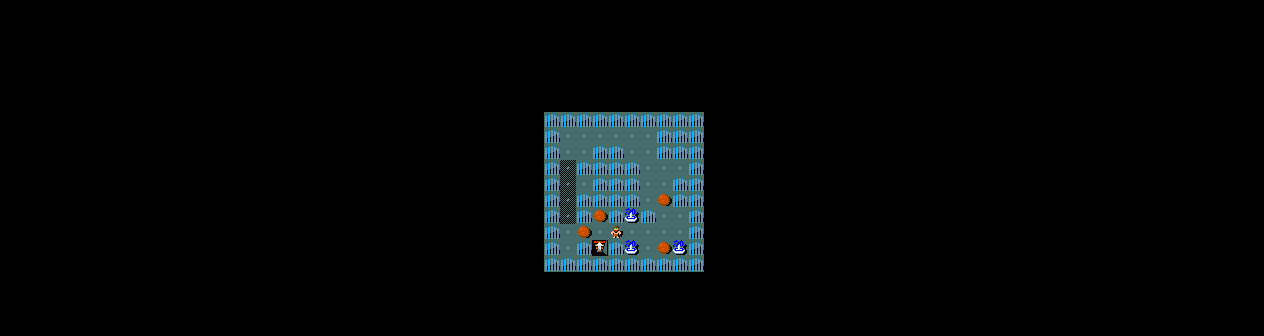

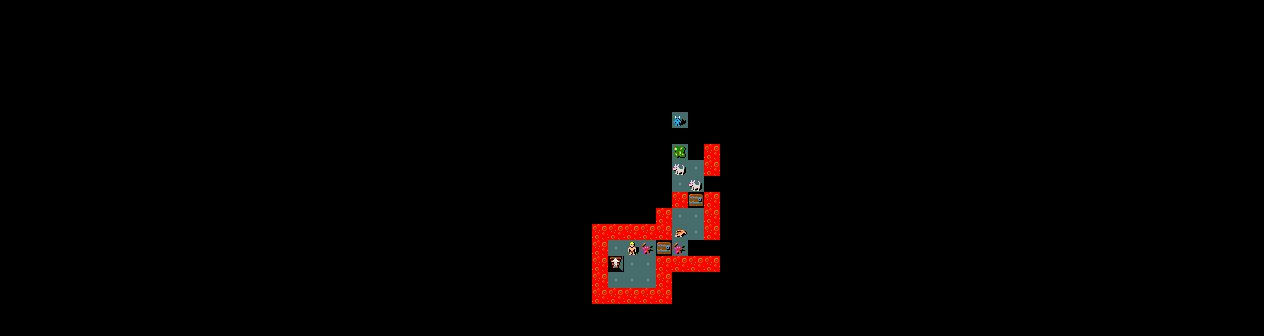

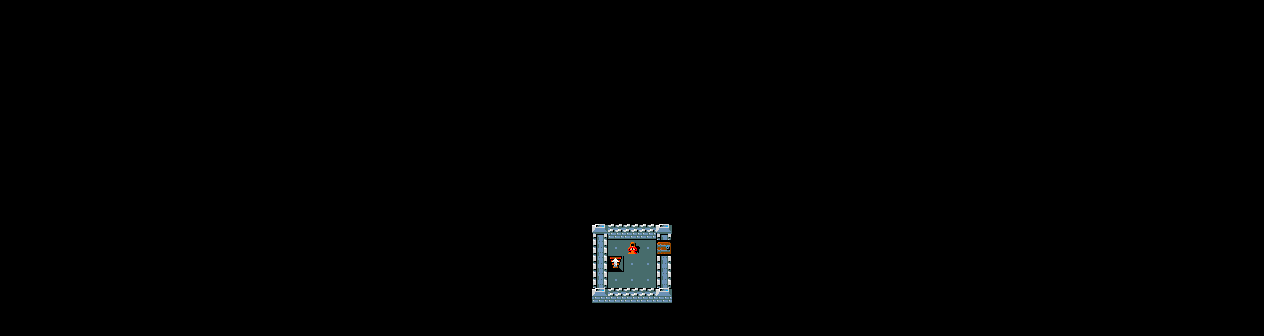

In [12]:
from nle.minihack.envs.river import MiniHackRiverLava
from nle.minihack.envs.boxohack import MiniHackBoxobanMedium


env = MiniHackBoxobanMedium(savedir=None,archivefile=None,observation_keys=observation_keys,wizard=True)
obs = env.reset()
for c in "#wizintrinsic\rt\r\r":
    obs,sds = env.env.step(ord(c))

obs,_,_,_ =env.step(0)
obs,_,_,_ =env.step(1)

x = display(obs["pixel"],)

from nle.minihack.envs.minigrid import MiniHackMultiRoomN4Extreme,MiniHackMultiRoomN4

n = 14
env = MiniHackMultiRoomN4Extreme(savedir=None,archivefile=None,observation_keys=observation_keys,wizard=True)
for _i in range(n):
    obs = env.reset()

for c in "#wizintrinsic\rt\r\r":
    obs,sds = env.env.step(ord(c))

obs,_,_,_ =env.step(0)
obs,_,_,_ =env.step(1)

x = display(obs["pixel"],)


env = MiniHackMultiRoomN4(savedir=None,archivefile=None,observation_keys=observation_keys,wizard=True)
for _i in range(n):
    obs = env.reset()

for c in "#wizintrinsic\rt\r\r":
    obs,sds = env.env.step(ord(c))

obs,_,_,_ =env.step(0)
obs,_,_,_ =env.step(1)

x = display(obs["pixel"],)


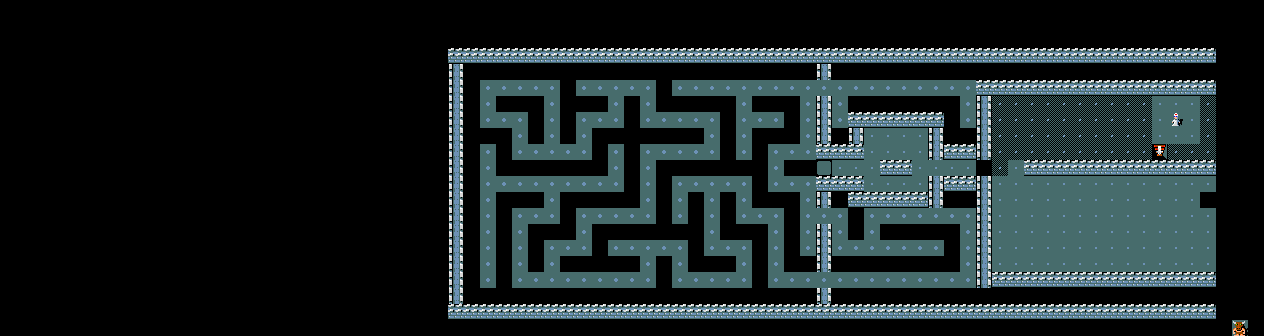

In [13]:
des_c = """
MAZE:"mylevel",' '
FLAGS: noteleport,corrmaze,premapped
GEOMETRY:right,center
# the two pools are fakes used to mark spots which need special wall fixups
# the two iron bars are eyes and spots to their left will be made diggable
MAP
------------------------------------------------
|                      |
|                      |         ---------------
|                      |         |..............
|                      | ------  |..............
|                      | |....|  |..............
|                      ---....|--|..............
|                      +...--....S..------------
|                      ---....|--|..............
|                      | -----|  |.............
|                      |         |..............
|                      |         |..............
|                      |         |..............
|                      |         |..............
|                      |         |--------------
|                      |
------------------------------------------------
ENDMAP

BRANCH:levregion(01,00,15,20),levregion(15,1,70,16)

# this actually leaves the farthest right column diggable
NON_DIGGABLE:(00,00,47,12)
MAZEWALK:(06,06),west
STAIR:(44,06),down

# The fellow in residence
MONSTER:('H',"minotaur"),(55,06)

# Random monsters.

"""
vis_des(des_c)

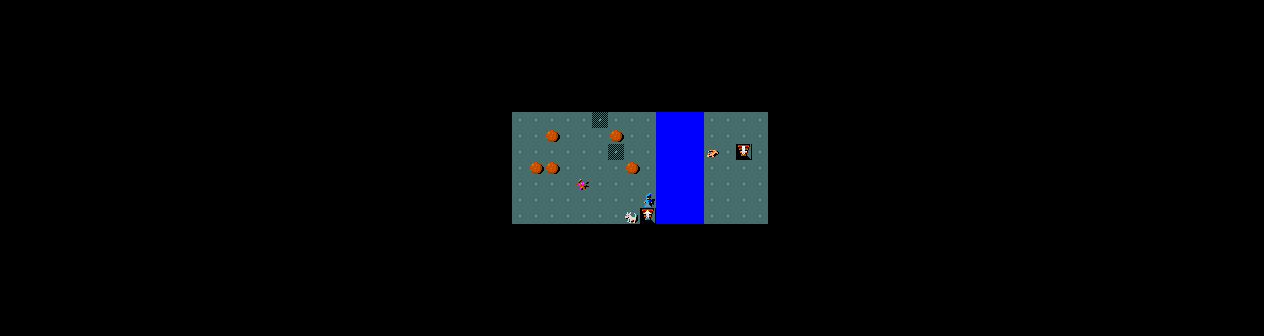

In [14]:
from nle.minihack.envs.river import MiniHackRiverMonster

des_river="""
MAZE: "mylevel", ' '
FLAGS:premapped
MESSAGE: "Welcome to MiniHack!"
INIT_MAP: solidfill,' '
GEOMETRY:center,center
MAP
.........WWW....
.........WWW....
.........WWW....
.........WWW....
.........WWW....
.........WWW....
.........WWW....
ENDMAP
REGION:(0,0,25,7),lit,"ordinary"
BRANCH:(0,0,8,6),(0,0,0,0)
MONSTER:random,random
MONSTER:random,random
MONSTER:random,random
$boulder_area = selection:fillrect (1,1,8,5)
OBJECT:('`',"boulder"),rndcoord($boulder_area)
OBJECT:('`',"boulder"),rndcoord($boulder_area)
OBJECT:('`',"boulder"),rndcoord($boulder_area)
OBJECT:('`',"boulder"),rndcoord($boulder_area)
OBJECT:('`',"boulder"),rndcoord($boulder_area)
STAIR:(14, 2),down
"""

vis_des(des_river)


In [15]:
# More reliable test
# Creating custom MiniHack task with many objects

from nle.minihack import MiniHackSkill, LevelGenerator

class MiniHackGUITest(MiniHackSkill):
    """Environment for "eat" task."""

    def __init__(self, *args, obs_crop_h=5, obs_crop_w=5, **kwargs):
        lvl_gen = LevelGenerator(w=5, h=5, lit=True)
        lvl_gen.add_stair_up((2, 2))

        lvl_gen.add_object("apple", "%", place=(1, 1))
        #lvl_gen.add_object("pear", "%", place=(0, 1))
        lvl_gen.add_object("dagger", ")", place=(0, 2))
        #lvl_gen.add_object("robe", "[", place=(0, 3))
        lvl_gen.add_object("boulder", "`", place=(1, 4))

        lvl_gen.add_terrain((0, 0), "W")  # water
        lvl_gen.add_terrain((0, 1), "W")  # lava
        lvl_gen.add_terrain((0, 2), "W")  # tree
        lvl_gen.add_terrain((0, 3), "W")  # fountain
        lvl_gen.add_terrain((0, 4), "W")  # iron bars

        lvl_gen.add_terrain((4, 0), "|")
        lvl_gen.add_terrain((4, 1), "|")
        lvl_gen.add_terrain((4, 2), "|")
        lvl_gen.add_terrain((4, 3), "|")
        lvl_gen.add_terrain((4, 4), "|")
        #lvl_gen.add_door("open", place=(4, 1))
        lvl_gen.add_door("closed", place=(4, 3))

        lvl_gen.add_monster("killer bee", place=(3, 0))
        #lvl_gen.add_monster("oracle", place=(3, 1))
        #lvl_gen.add_monster("famine", place=(3, 2))
        #lvl_gen.add_monster("giant ant", place=(3, 3))
        lvl_gen.add_monster("green dragon", place=(3, 4))

        des_file = lvl_gen.get_des()

        kwargs["observation_keys"] = (
            "glyphs_crop",
            "screen_descriptions_crop",
            "pixel_crop",
            "pixel",
        )

        super().__init__(*args, des_file=des_file, **kwargs)


In [16]:
# Textual descriptions
env = MiniHackGUITest(savedir=None,archivefile=None)
obs = env.reset()

# Glyphs
glyphs = obs["glyphs_crop"]

screen_description = obs["screen_descriptions_crop"]

env.render(mode="human")

Hello Agent, welcome to NetHack!  You are a neutral human Caveman.              
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                    }..a|                                       
                                    }%..|                                       
                            

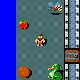

In [17]:
def vis5(x):
    x = x[9*16:14*16,36*16:41*16,:]
    display(x)
    return x

x = vis5(obs["pixel"],)
save(x, "obs_pixel.png")

In [18]:
for i in range(glyphs.shape[0]):
    str_row = ""
    for j in range(glyphs.shape[1]):
        string = screen_description[i, j].tobytes().decode("utf-8")
        str_row += "\t" + f"\"{string}\""
    print(str_row)

	"  water                                                                             "	"  floor of a room                                                                   "	"  floor of a room                                                                   "	"  killer bee                                                                        "	"  wall                                                                              "
	"  water                                                                             "	"  an apple                                                                          "	"  floor of a room                                                                   "	"  floor of a room                                                                   "	"  wall                                                                              "
	"  water                                                                             "	"  floor of a room                      

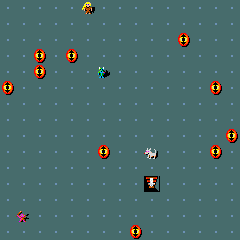

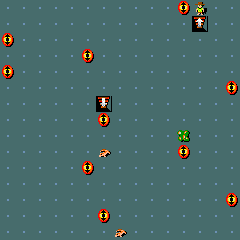

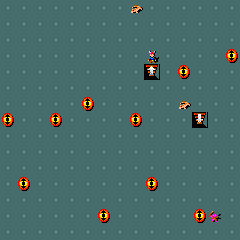

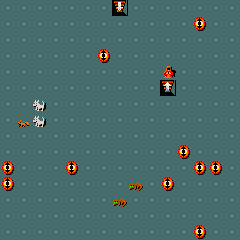

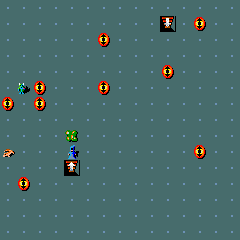

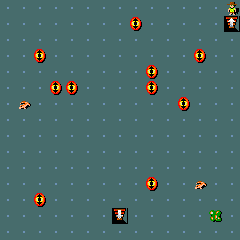

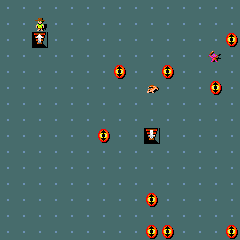

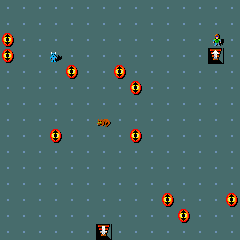

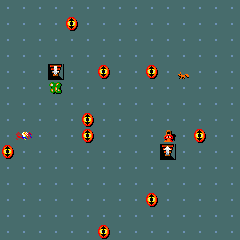

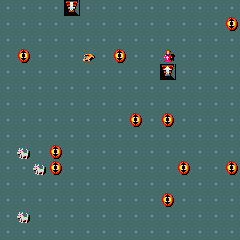

In [46]:
from nle.minihack.envs.room import MiniHackRoom

def vis15(x):
    m = 3
    n= 32
    
    x = x[m*16:(m+15)*16,n*16:(n+15)*16,:]
    display(x)
    return x

for i in range(10):
    env = MiniHackRoom(savedir=None, archivefile=None,observation_keys=observation_keys,wizard=True,n_monster=3, size=15,n_trap=10)
    obs = env.reset()
    
    for c in "#wizintrinsic\rt\r\r":
        obs,sds = env.env.step(ord(c))
        
    for c in "#wizmap\r":
        obs,sds = env.env.step(ord(c))

    obs,_,_,_ =env.step(0)
    
    x = vis15(obs["pixel"],)
    save(x, "rooms", "room_{}".format(i))

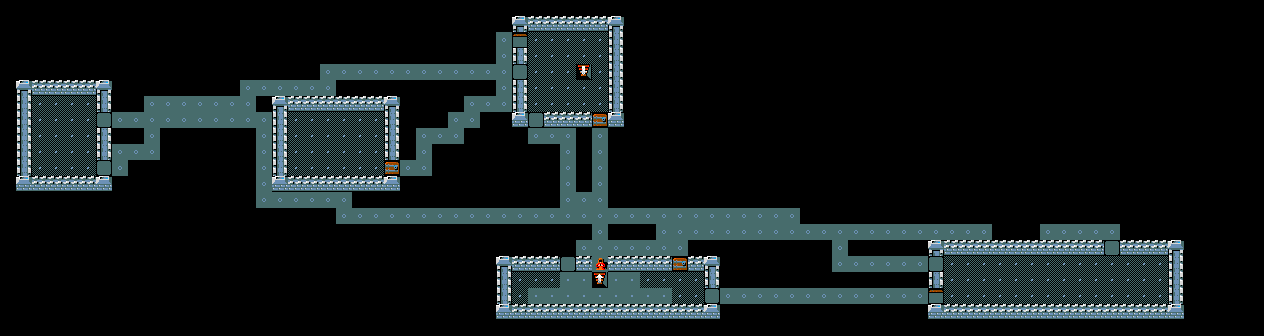

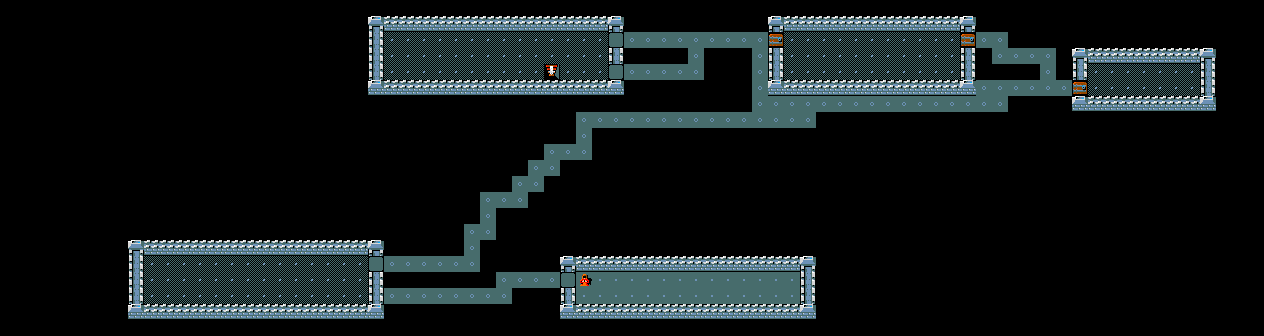

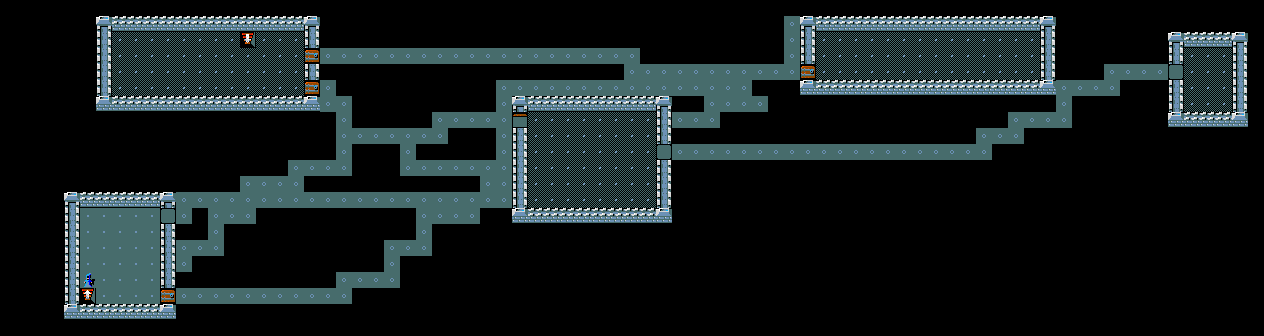

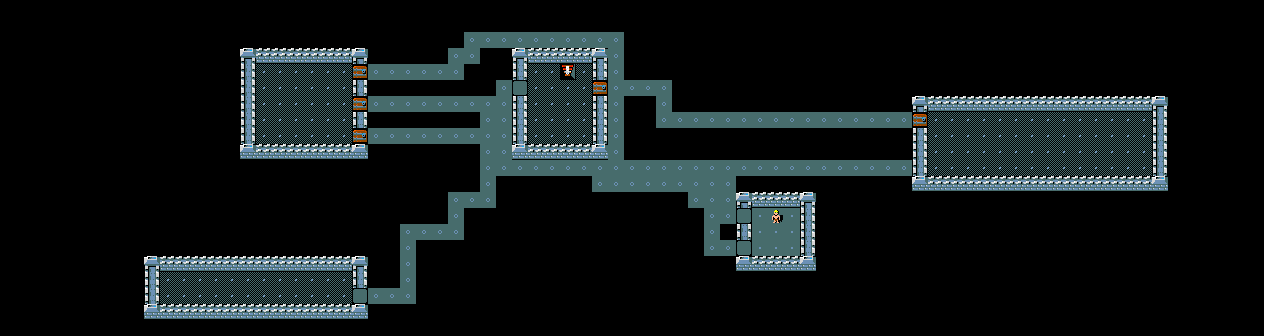

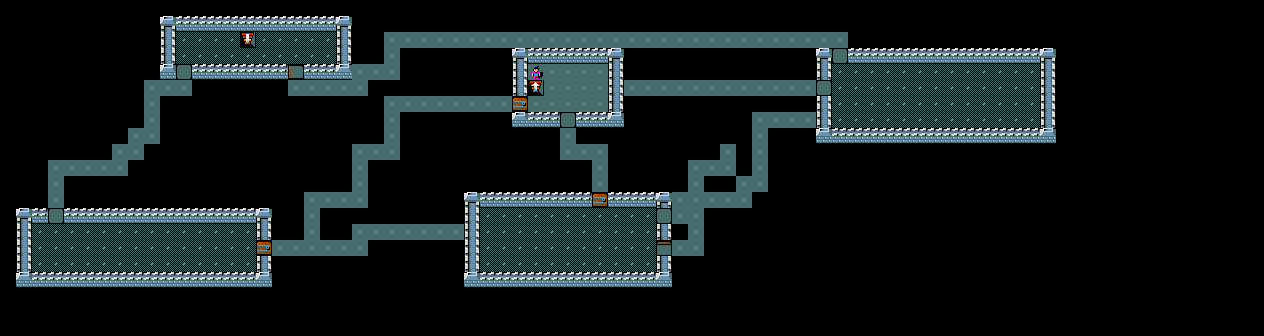

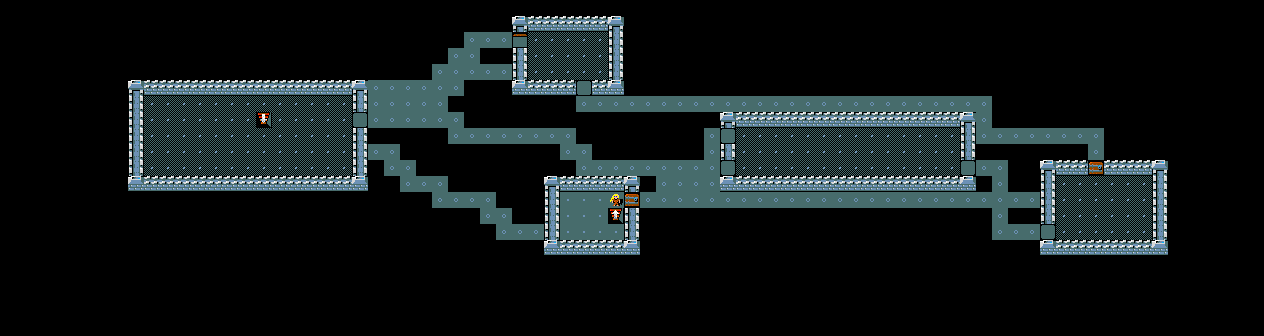

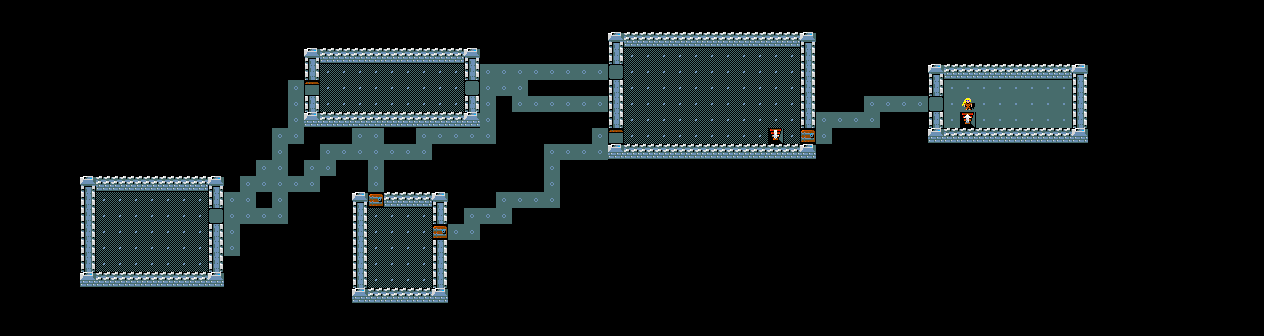

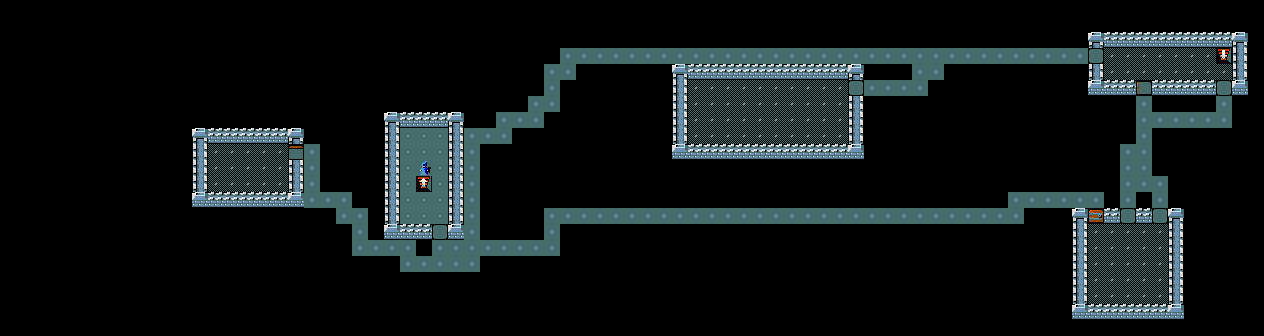

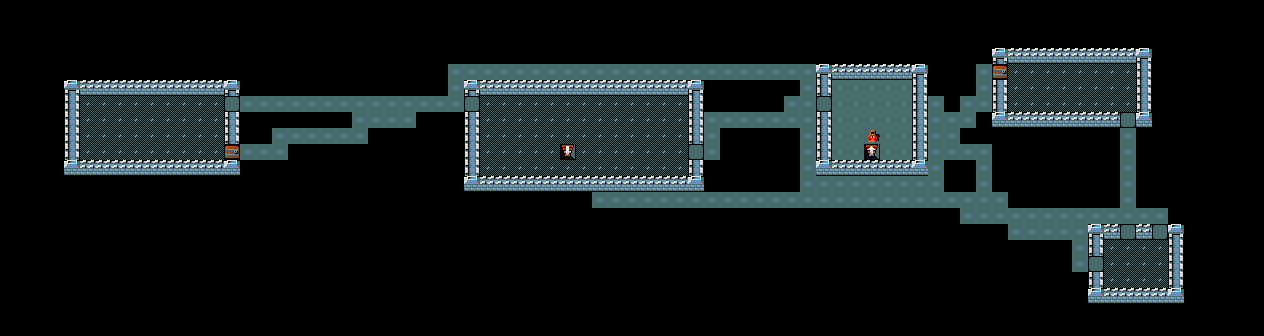

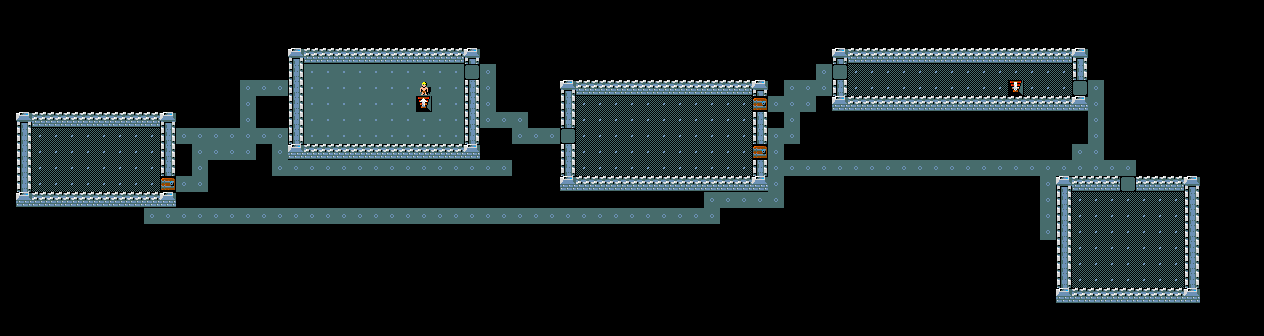

In [54]:
from nle.minihack.envs.corridor import MiniHackCorridor5 as MH

def vis15(x):
    m = 3
    n= 32
    
    x = x[m*16:(m+15)*16,n*16:(n+15)*16,:]
    display(x)
    return x

for i in range(10):
    env = MH(savedir=None, archivefile=None,observation_keys=observation_keys,wizard=True)
    obs = env.reset()
    
    for c in "#wizintrinsic\rt\r\r":
        obs,sds = env.env.step(ord(c))
        
    for c in "#wizmap\r":
        obs,sds = env.env.step(ord(c))

    obs,_,_,_ =env.step(0)
    
    x = display(obs["pixel"],)
#     save(x, "corr", "corr_{}".format(i))

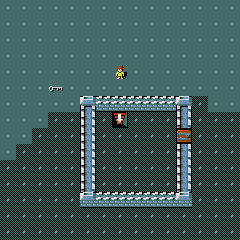

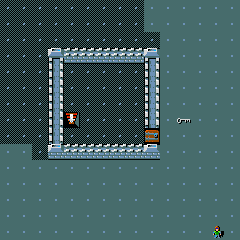

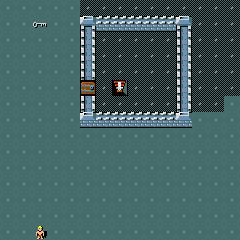

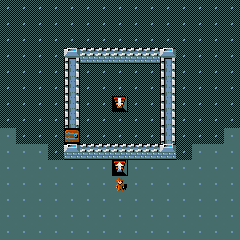

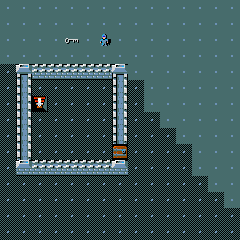

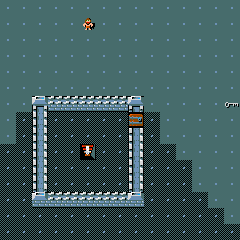

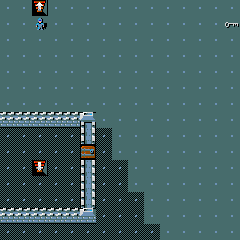

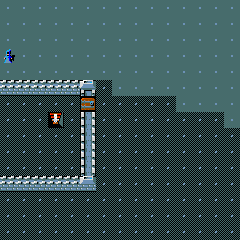

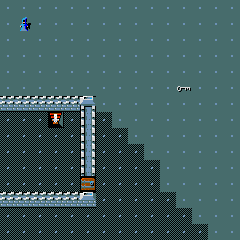

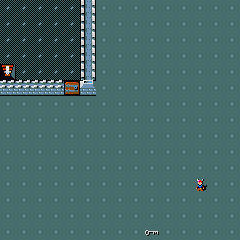

In [60]:
from nle.minihack.envs.keyroom import MiniHackKeyRoom15x15 as MH

def vis15(x):
    m = 4
    n= 32
    
    x = x[m*16:(m+15)*16,n*16:(n+15)*16,:]
    display(x)
    return x

for i in range(10):
    env = MH(savedir=None, archivefile=None,observation_keys=observation_keys,wizard=True)
    obs = env.reset()
    
    for c in "#wizintrinsic\rt\r\r":
        obs,sds = env.env.step(ord(c))
        
    for c in "#wizmap\r":
        obs,sds = env.env.step(ord(c))

    obs,_,_,_ =env.step(0)
    obs,_,_,_ =env.step(2)
    
    x = vis15(obs["pixel"],)
    save(x, "keyroom", "keyroom_{}".format(i))

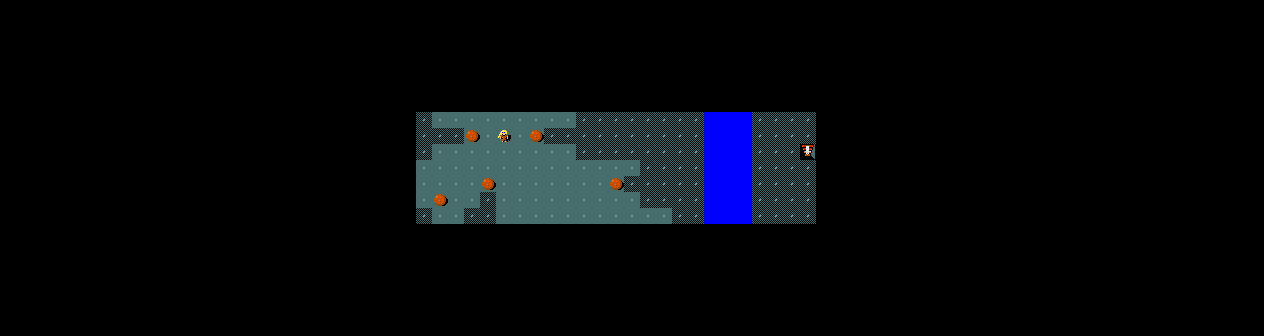

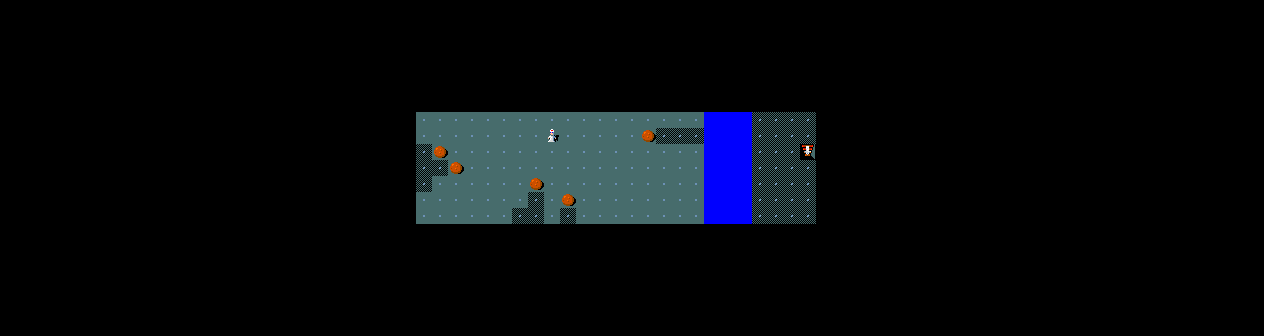

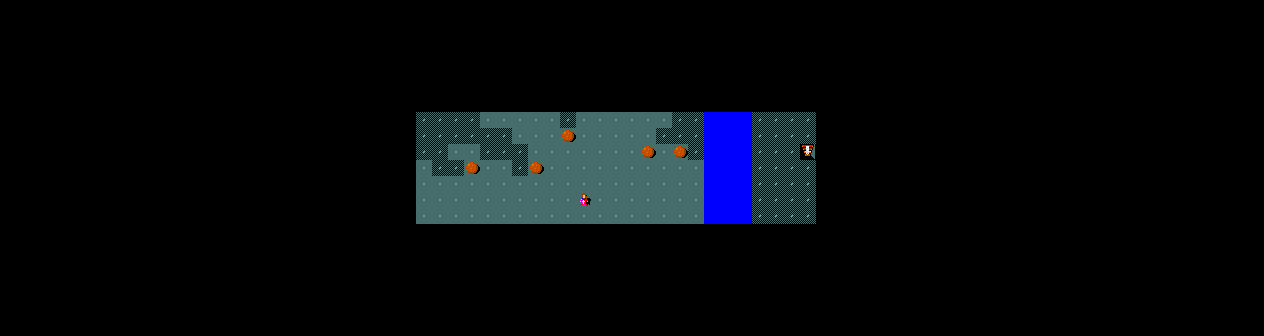

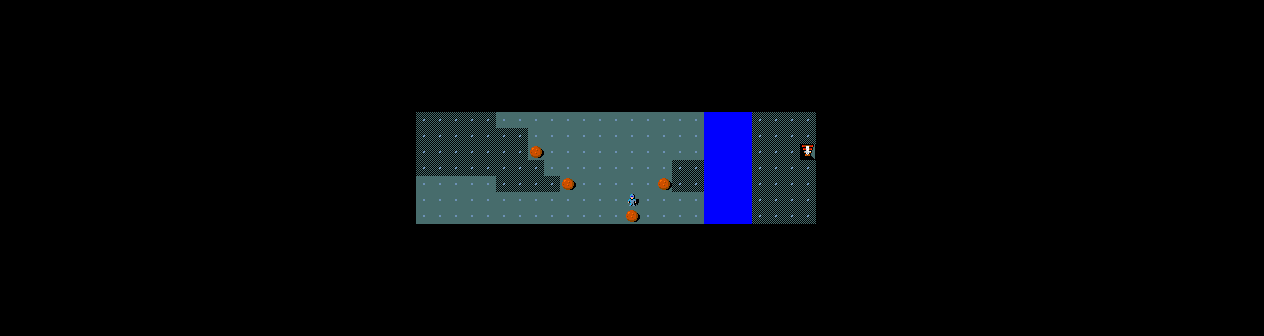

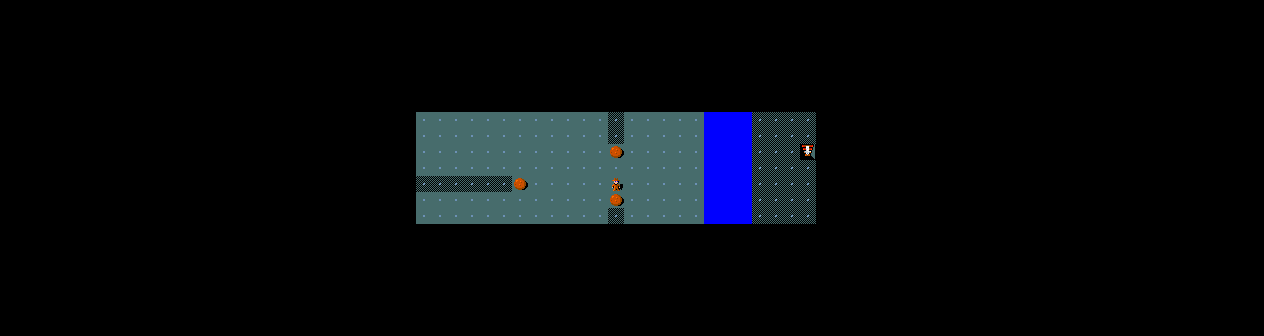

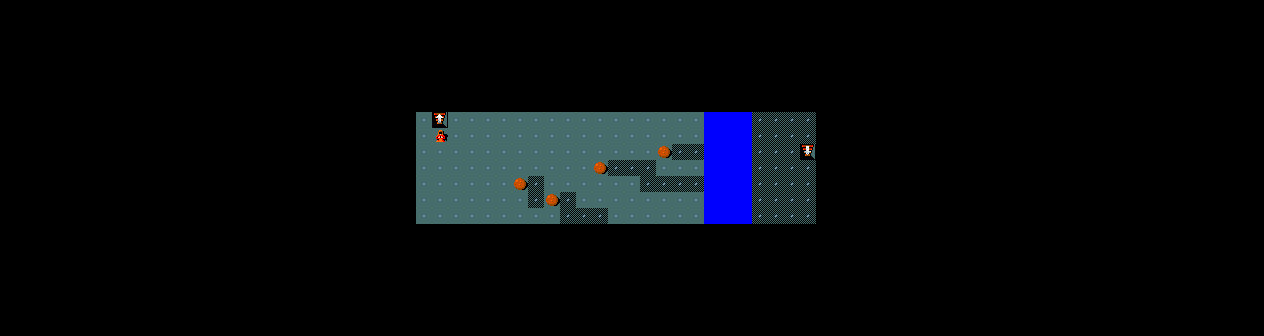

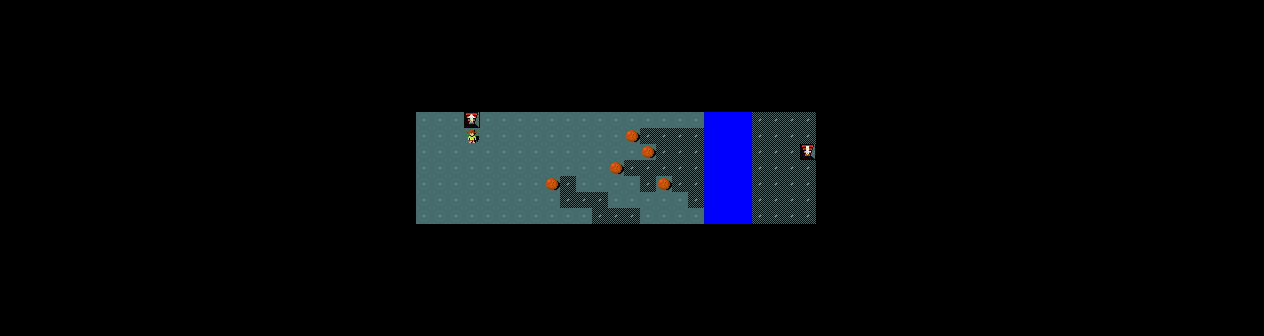

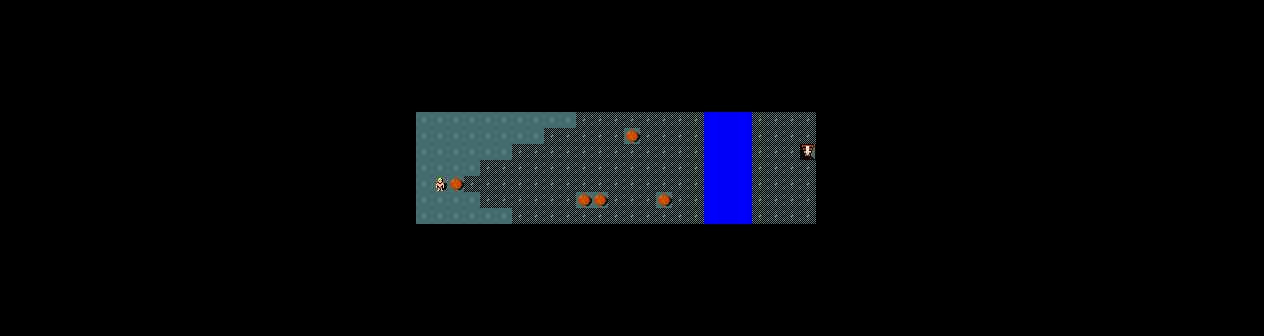

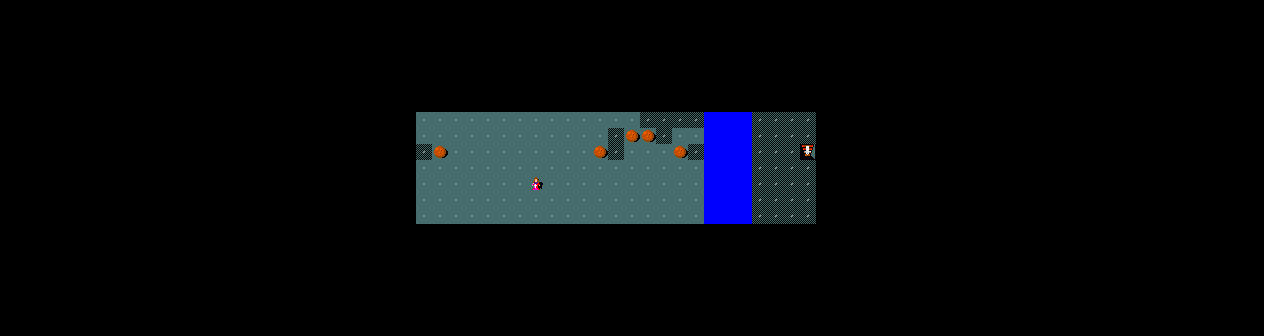

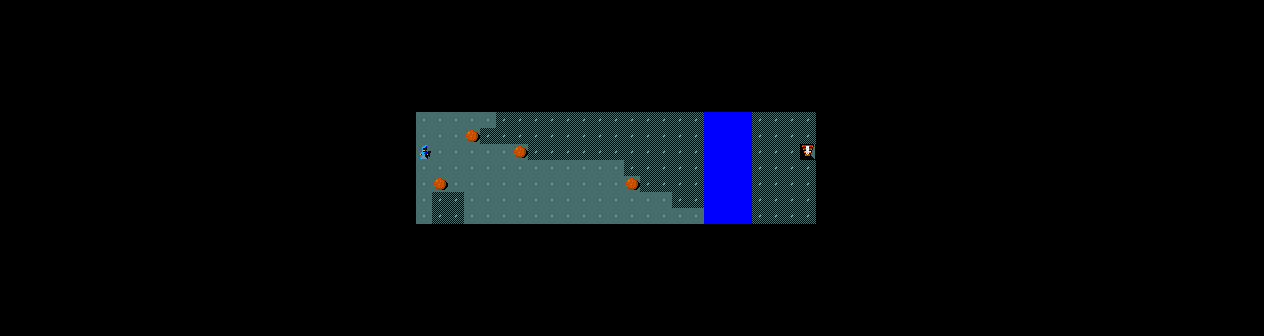

In [67]:
class MiniHackRiver(MiniHackNavigation):
    def __init__(self, *args, **kwargs):
        kwargs["max_episode_steps"] = kwargs.pop("max_episode_steps", 350)
        n_monster = kwargs.pop("n_monster", 0)
        n_boulder = kwargs.pop("n_boulder", 5)
        narrow = kwargs.pop("narrow", False)
        lava = kwargs.pop("lava", False)

        if narrow:
            map = """
..................WW.....
..................WW.....
..................WW.....
..................WW.....
..................WW.....
..................WW.....
..................WW.....
"""
        elif not lava:
            map = """
..................WWW....
..................WWW....
..................WWW....
..................WWW....
..................WWW....
..................WWW....
..................WWW....
"""
        else:
            map = """
..................LLL....
..................LLL....
..................WWW....
..................LLL....
..................WWW....
..................LLL....
..................LLL....
"""

        lvl_gen = LevelGenerator(map=map)
        lvl_gen.set_start_rect((0, 0), (18, 6))

        for _ in range(n_monster):
            lvl_gen.add_monster()

        lvl_gen.set_area_variable(
            "$boulder_area", type="fillrect", x1=1, y1=1, x2=18, y2=5
        )
        for _ in range(n_boulder):
            lvl_gen.add_object_area("$boulder_area", name="boulder", symbol="`")

        lvl_gen.add_goal_pos((24, 2))

        super().__init__(*args, des_file=lvl_gen.get_des(), **kwargs)

def vis15(x):
    m = 4
    n= 32
    
    x = x[m*16:(m+15)*16,n*16:(n+15)*16,:]
    display(x)
    return x

for i in range(10):
    env = MiniHackRiver(savedir=None, archivefile=None,observation_keys=observation_keys,wizard=True)
    obs = env.reset()
    
    for c in "#wizintrinsic\rt\r\r":
        obs,sds = env.env.step(ord(c))
        
    for c in "#wizmap\r":
        obs,sds = env.env.step(ord(c))

    obs,_,_,_ =env.step(0)
    obs,_,_,_ =env.step(2)
    
    x = display(obs["pixel"],)
#     save(x, "keyroom", "keyroom_{}".format(i))

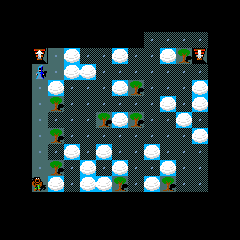

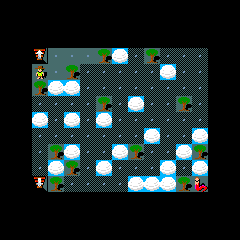

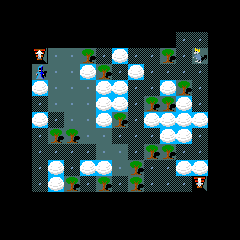

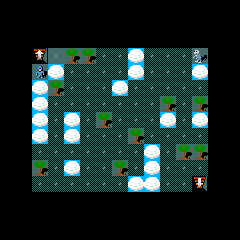

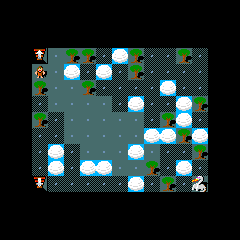

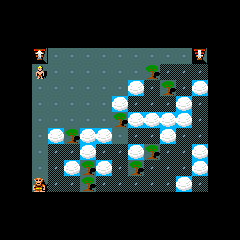

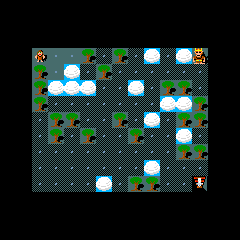

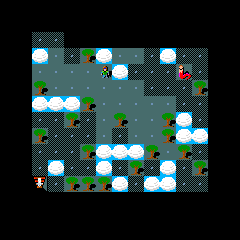

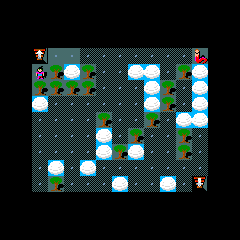

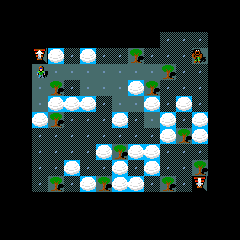

In [69]:
from nle.minihack.envs.hidenseek import MiniHackHideAndSeek as MH

def vis15(x):
    m = 4
    n= 32
    
    x = x[m*16:(m+15)*16,n*16:(n+15)*16,:]
    display(x)
    return x

for i in range(10):
    env = MH(savedir=None, archivefile=None,observation_keys=observation_keys,wizard=True)
    obs = env.reset()
    
    for c in "#wizintrinsic\rt\r\r":
        obs,sds = env.env.step(ord(c))
        
    for c in "#wizmap\r":
        obs,sds = env.env.step(ord(c))

    obs,_,_,_ =env.step(0)
    obs,_,_,_ =env.step(2)
    
    x = vis15(obs["pixel"],)
    save(x, "keyroom", "keyroom_{}".format(i))

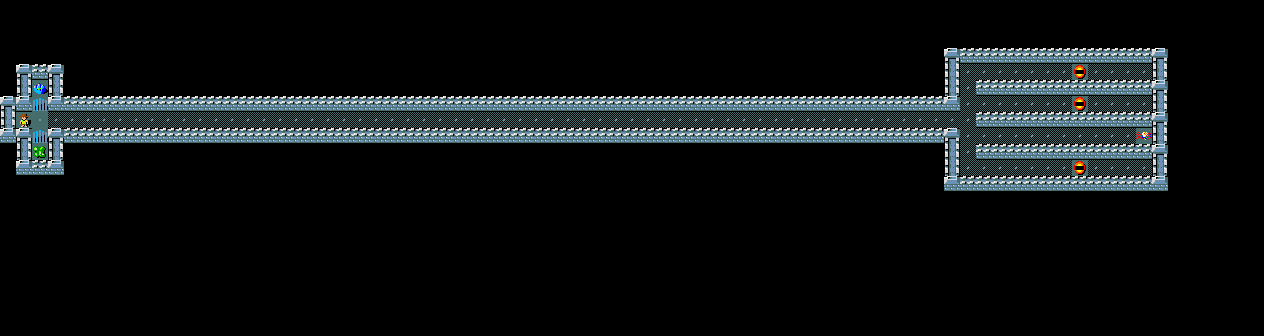

In [71]:
des_memento = """
MAZE: "mylevel",' '
INIT_MAP:solidfill,' '
GEOMETRY:left,top
MAP
                                                           --------------
 ---                                                       |............|
 |.|                                                       |.-----------|
--F|-------------------------------------------------------|............|
|............................................................-----------|
--F--------------------------------------------------------|............|
 |.|                                                       |.-----------|
 ---                                                       |............|
                                                           --------------
ENDMAP
REGION:(0,0,11,80),unlit,"ordinary"
REGION:(0,2,2,2),lit,"ordinary"
REGION:(0,6,3,6),lit,"ordinary"
IF [50%] {
  IF [50%] {
    # Prompt
    MONSTER: ('j', "blue jelly"),(2,2),asleep
    MONSTER: ('F', "red mold"),(2,6),asleep
    # Failure
    TRAP:"board", (67,7)
    TRAP:"board", (67,5)
    TRAP:"board", (67,3)
    # Success
    MONSTER: ('x', "grid bug"),(71,1),asleep
  } ELSE {
    # Prompt
    MONSTER: ('j', "spotted jelly"),(2,2),asleep
    MONSTER: ('F', "red mold"),(2,6),asleep
    # Failure
    TRAP:"board", (67,7)
    TRAP:"board", (67,5)
    TRAP:"board", (67,1)
    # Success
    MONSTER: ('x', "grid bug"),(71,3),asleep
  }
} ELSE {
  IF [50%] {
    # Prompt
    MONSTER: ('j', "blue jelly"),(2,2),asleep
    MONSTER: ('F', "green mold"),(2,6),asleep
    # Failure
    TRAP:"board", (67,7)
    TRAP:"board", (67,3)
    TRAP:"board", (67,1)
    # Success
    MONSTER: ('x', "grid bug"),(71,5),asleep
  } ELSE {
    # Prompt
    MONSTER: ('j', "spotted jelly"),(2,2),asleep
    MONSTER: ('F', "green mold"),(2,6),asleep
    # Failure
    TRAP:"board", (67,5)
    TRAP:"board", (67,3)
    TRAP:"board", (67,1)
    # Success
    MONSTER: ('x', "grid bug"),(71,7),asleep
  }
}
BRANCH:(1,4,1,4),(2,6,2,6)

"""
env = MiniHackNavigation(savedir=None,archivefile=None,observation_keys=observation_keys,wizard=True,des_file=des_memento)
obs = env.reset()
    
for c in "#wizintrinsic\rt\r\r":
    obs,sds = env.env.step(ord(c))

for c in "#wizmap\r":
    obs,sds = env.env.step(ord(c))

obs,_,_,_ =env.step(0)
obs,_,_,_ =env.step(2)

x = display(obs["pixel"],)

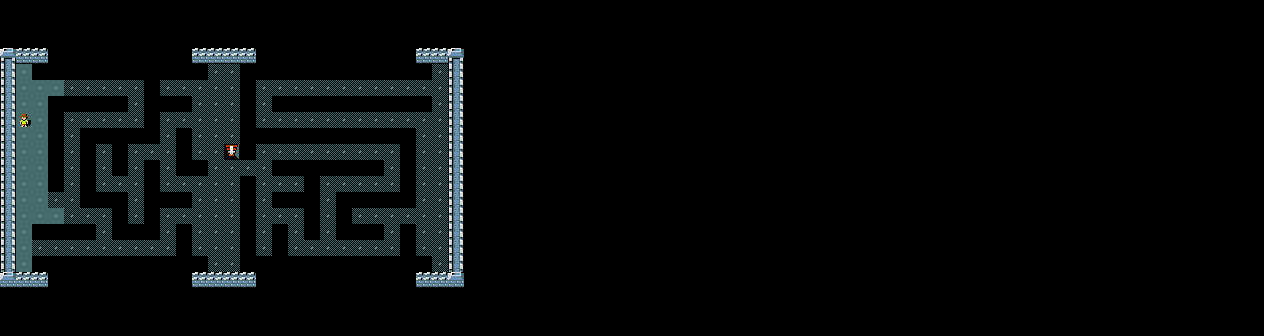

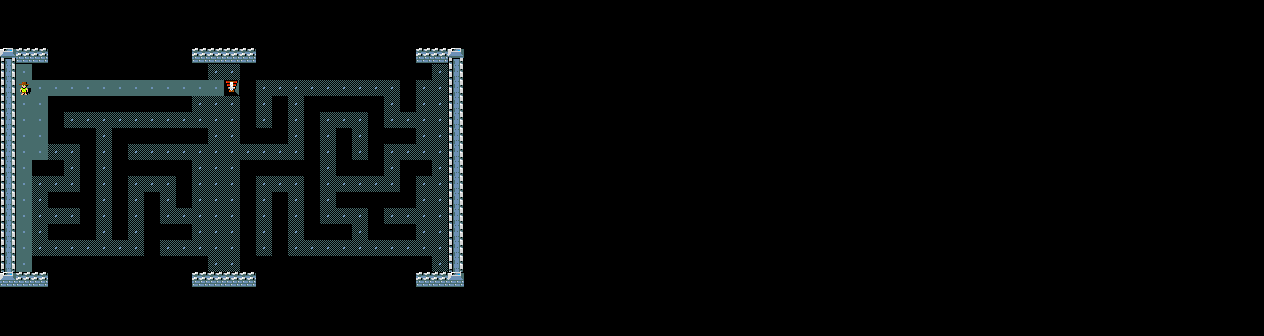

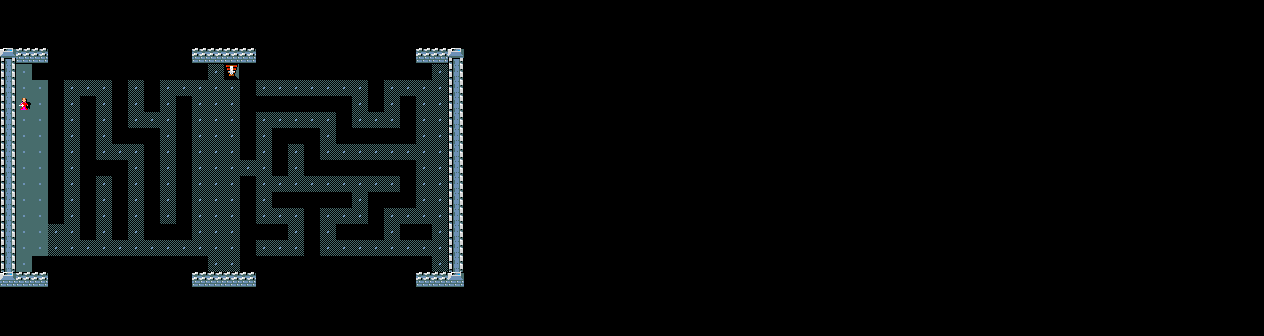

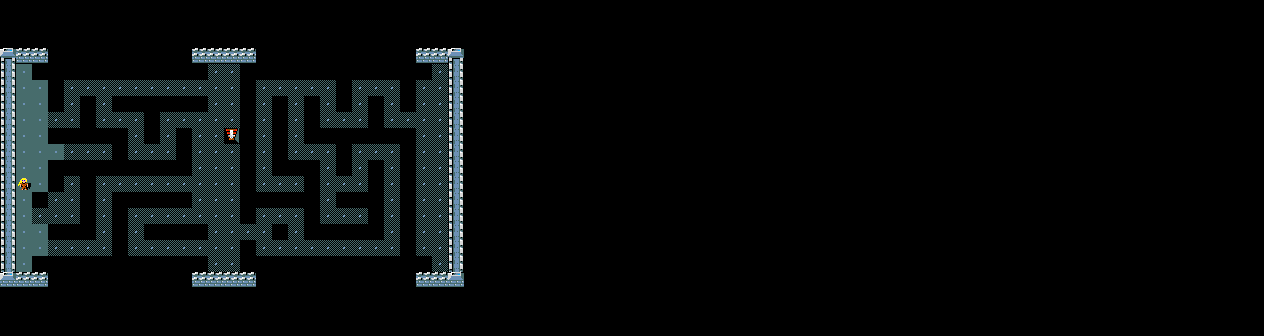

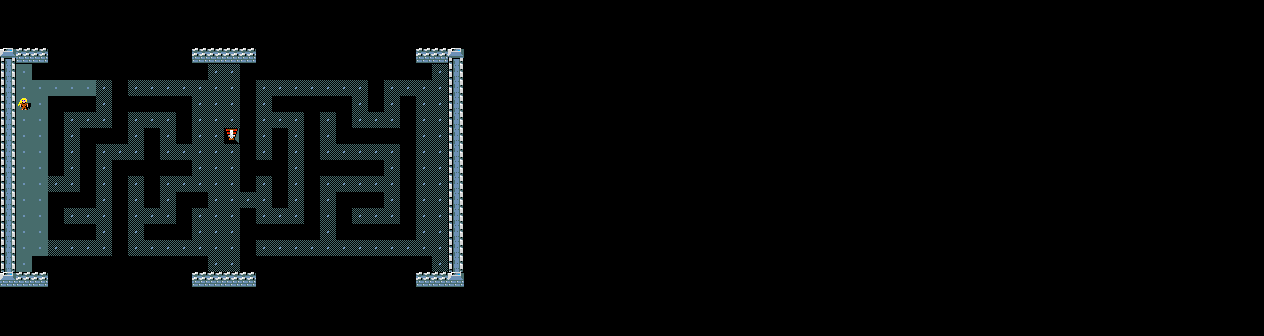

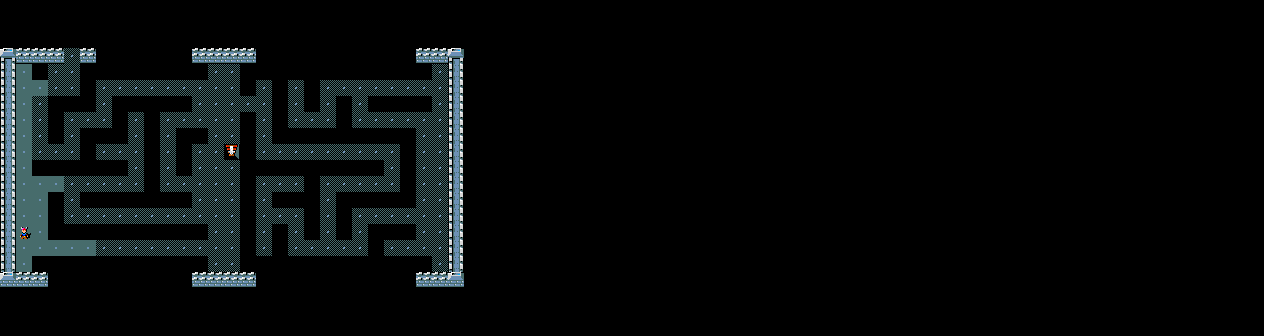

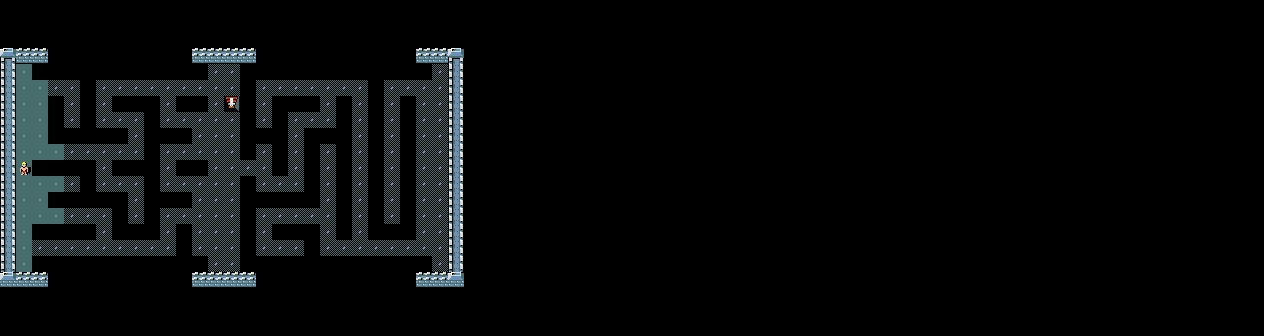

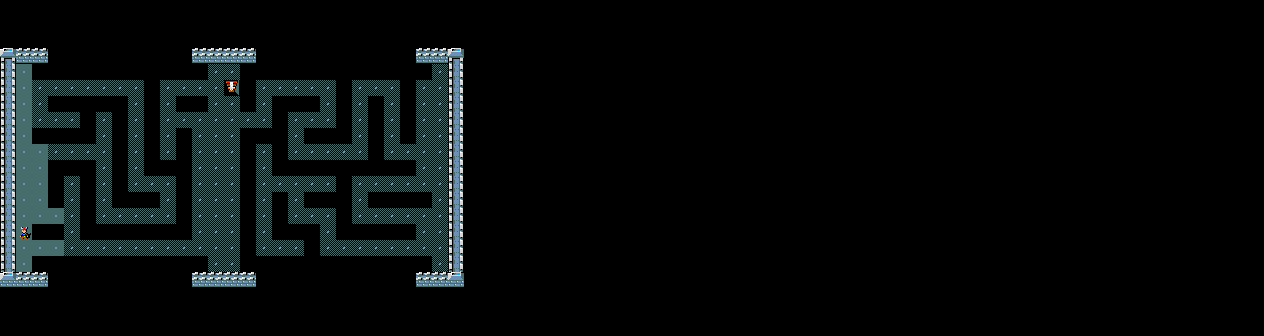

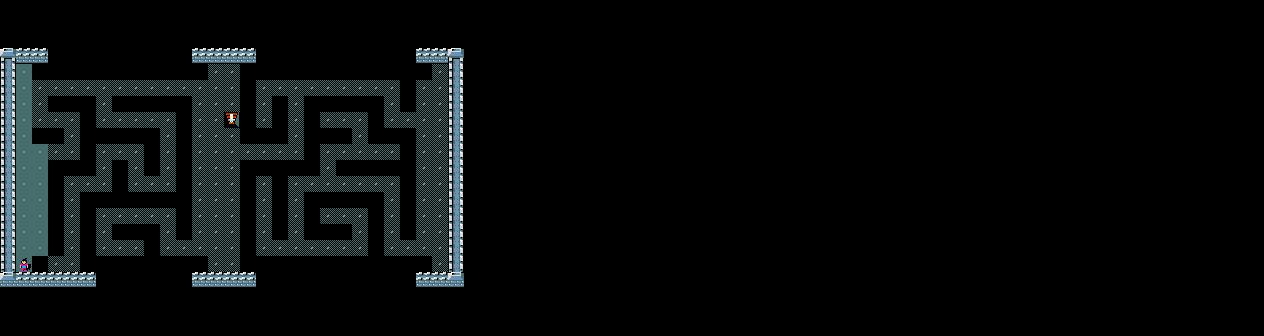

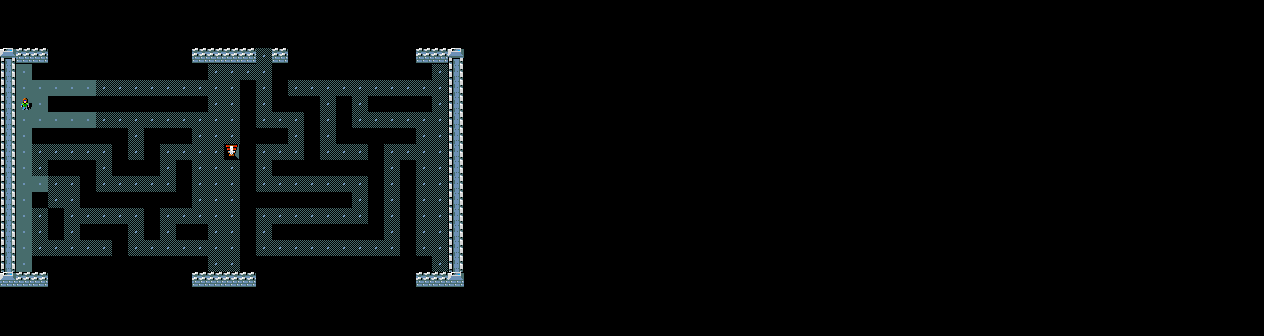

In [76]:
from nle.minihack.envs.exploremaze import MiniHackExploreMazeHardMapped as MH

def vis15(x):
    m = 4
    n= 32
    
    x = x[m*16:(m+15)*16,n*16:(n+15)*16,:]
    display(x)
    return x

for i in range(10):
    env = MH(savedir=None, archivefile=None,observation_keys=observation_keys,wizard=True)
    obs = env.reset()
    
    for c in "#wizintrinsic\rt\r\r":
        obs,sds = env.env.step(ord(c))
        
    for c in "#wizmap\r":
        obs,sds = env.env.step(ord(c))

    obs,_,_,_ =env.step(0)
    obs,_,_,_ =env.step(2)
    
    x = display(obs["pixel"],)
#     save(x, "keyroom", "keyroom_{}".format(i))

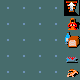

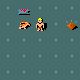

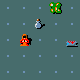

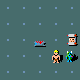

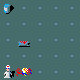

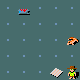

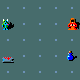

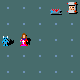

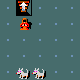

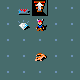

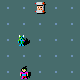

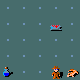

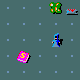

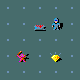

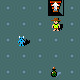

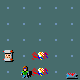

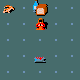

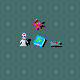

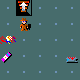

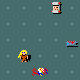

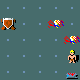

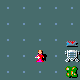

In [102]:
from nle.minihack.envs.skills_simple import MiniHackPrayDistr as MH



for i in range(22):
    env = MH(savedir=None, archivefile=None,observation_keys=observation_keys,wizard=True)
    obs = env.reset()
    
    for c in "#wizintrinsic\rt\r\r":
        obs,sds = env.env.step(ord(c))
        
    for c in "#wizmap\r":
        obs,sds = env.env.step(ord(c))

    obs,_,_,_ =env.step(0)
    obs,_,_,_ =env.step(2)
    
    x = vis5(obs["pixel"],)
#     save(x, "keyroom", "keyroom_{}".format(i))

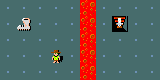

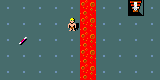

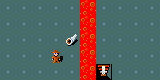

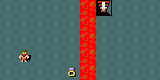

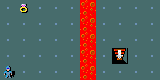

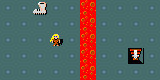

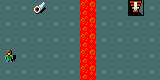

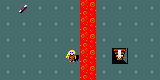

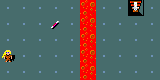

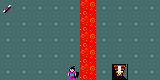

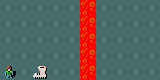

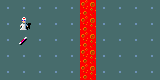

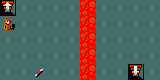

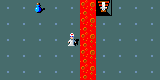

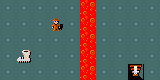

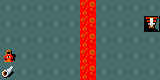

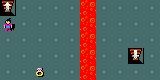

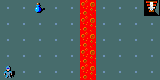

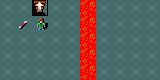

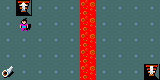

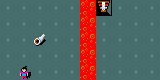

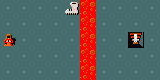

In [156]:
from nle.minihack.envs.skills_lava import MiniHackLC as MH

def vislava(x):
    m = 8
    n= 33
    
    x = x[m*16:(m+5)*16,n*16:(n+10)*16,:]
    display(x)
    return x

for i in range(22):
    env = MH(savedir=None, archivefile=None,observation_keys=observation_keys,wizard=True)
    obs = env.reset()
    
    for c in "#wizintrinsic\rt\r\r":
        obs,sds = env.env.step(ord(c))
        
    for c in "#wizmap\r":
        obs,sds = env.env.step(ord(c))

    obs,_,_,_ =env.step(0)
    obs,_,_,_ =env.step(2)
    
    x = vislava(obs["pixel"],)
#     save(x, "keyroom", "keyroom_{}".format(i))

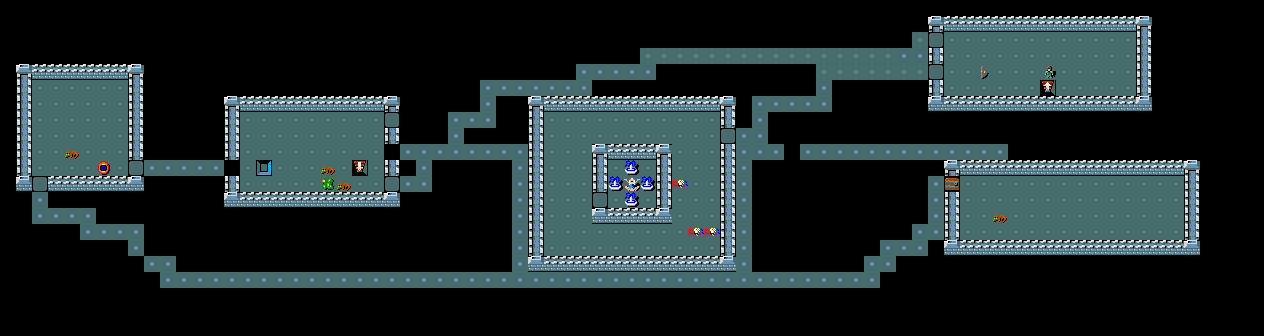

In [155]:
des_quest = """
# NetHack 3.6	oracle.des	$NHDT-Date: 1524689580 2018/04/25 20:53:00 $  $NHDT-Branch: NetHack-3.6.0 $:$NHDT-Revision: 1.10 $
# Copyright (c) 2015 by Pasi Kallinen
# NetHack may be freely redistributed.  See license for details.
#
# Oracle level
#

LEVEL: "mylevel"
FLAGS:premapped

ROOM: "ordinary" , lit, (3,3), (center,center), (11,9) {
  OBJECT:('`',"statue"),(0,0),montype:'C',1
  OBJECT:('`',"statue"),(0,8),montype:'C',1
  OBJECT:('`',"statue"),(10,0),montype:'C',1
  OBJECT:('`',"statue"),(10,8),montype:'C',1
  OBJECT:('`',"statue"),(5,1),montype:'C',1
  OBJECT:('`',"statue"),(5,7),montype:'C',1
  OBJECT:('`',"statue"),(2,4),montype:'C',1
  OBJECT:('`',"statue"),(8,4),montype:'C',1

  SUBROOM: "delphi" , lit , (4,3) , (3,3) {
    FOUNTAIN: (0, 1)
    FOUNTAIN: (1, 0)
    FOUNTAIN: (1, 2)
    FOUNTAIN: (2, 1)
    MONSTER: ('@', "Oracle"), (1,1)
    ROOMDOOR: false , nodoor , random, random
  }

  MONSTER: random, random
  MONSTER: random, random

}

ROOM: "ordinary" , random, random, random, random {
  STAIR: random, up
  OBJECT: random,random
}

ROOM: "ordinary" , random, random, random, random {
  STAIR: random, down
  OBJECT: random, random
  TRAP: random, random
  MONSTER: random, random
  MONSTER: random, random
}

ROOM: "ordinary" , random, random, random, random {
  OBJECT: random, random
  OBJECT: random, random
  MONSTER: random, random
}

ROOM: "ordinary" , random, random, random, random {
  OBJECT: random, random
  TRAP: random, random
  MONSTER: random, random
}

ROOM: "ordinary" , random, random, random, random {
  OBJECT: random, random
  TRAP: random, random
  MONSTER: random, random
}

RANDOM_CORRIDORS

"""
vis_des(des_quest)

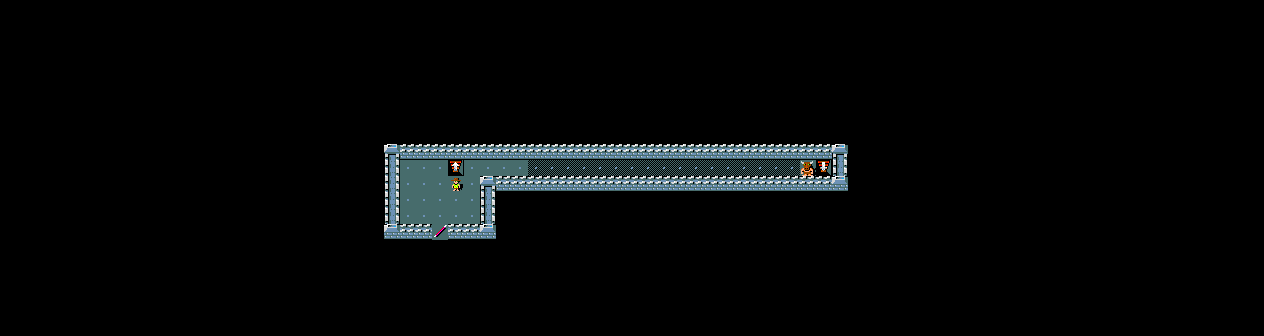

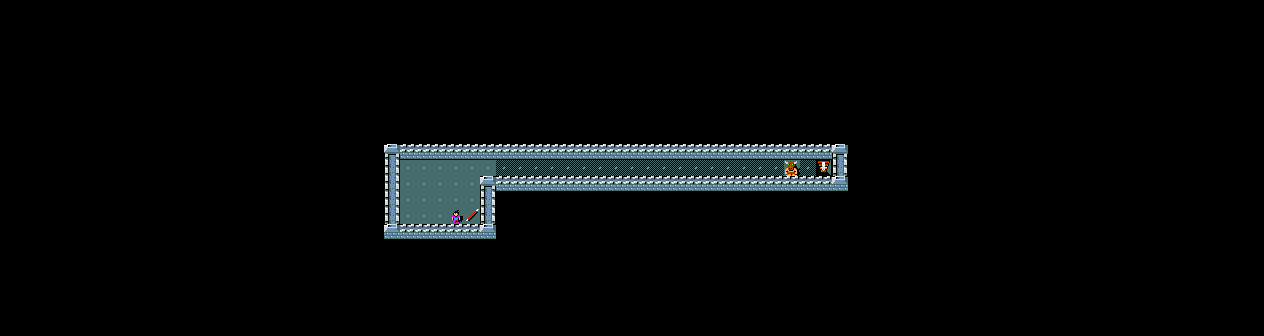

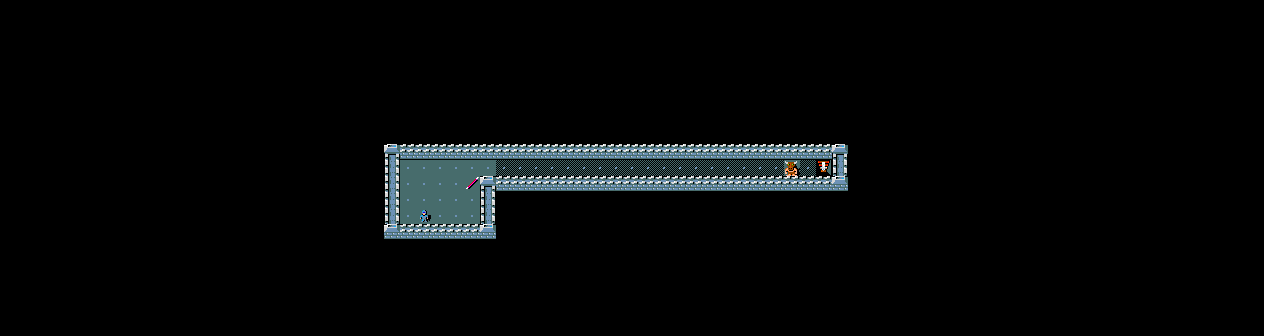

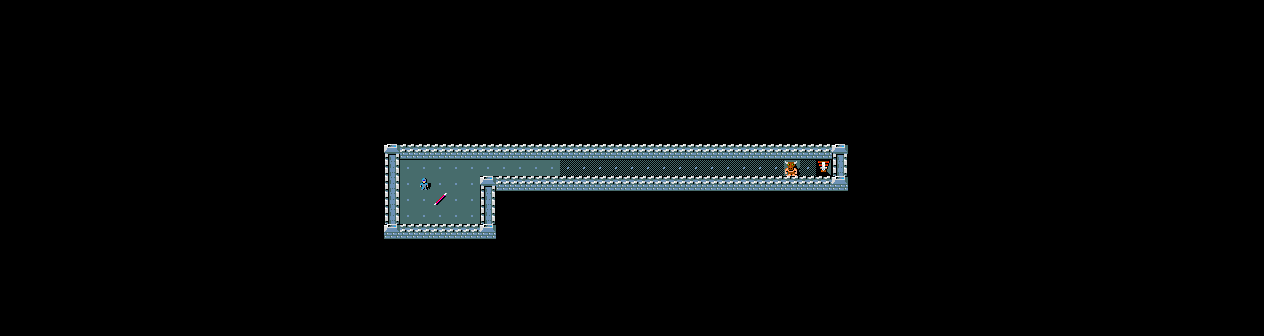

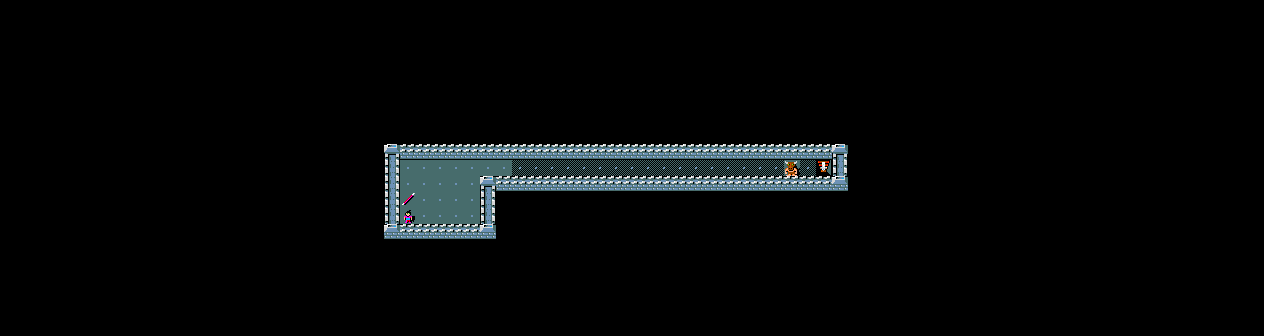

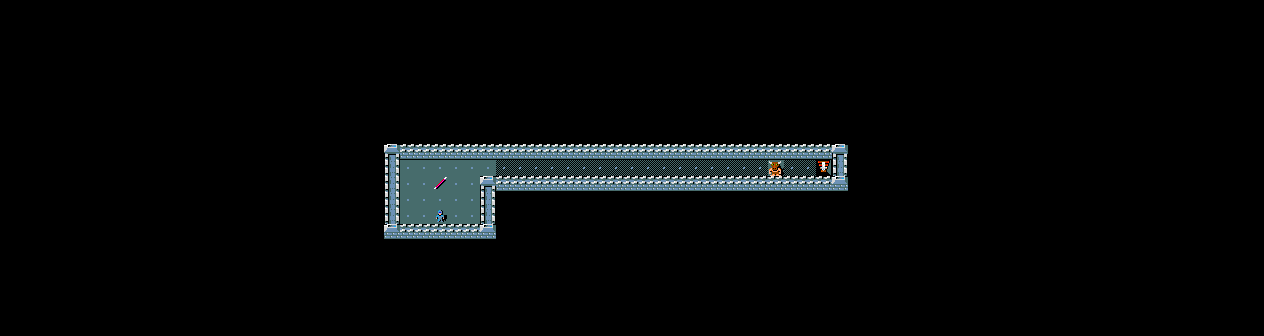

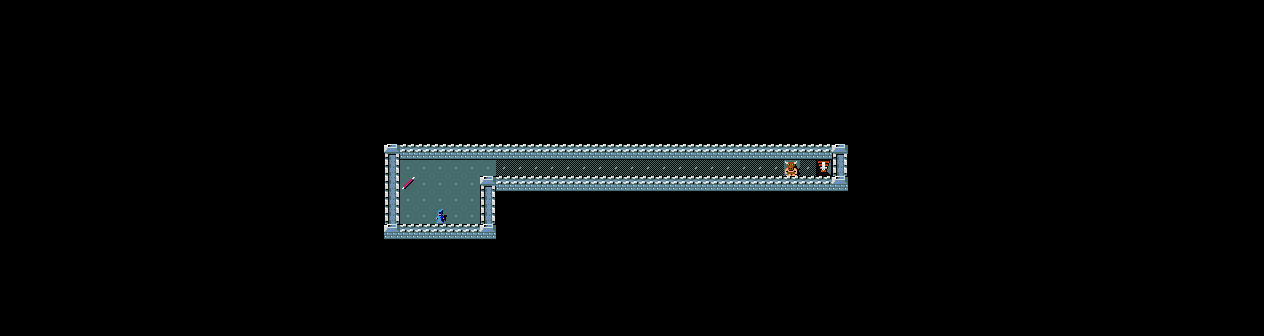

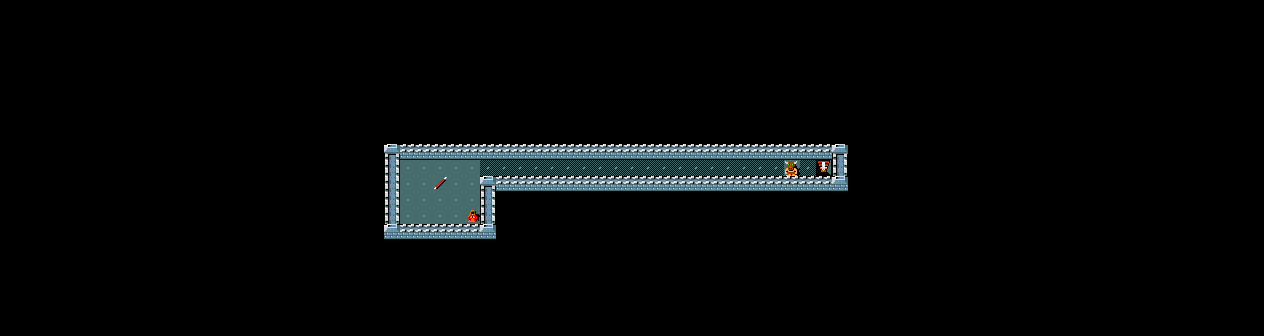

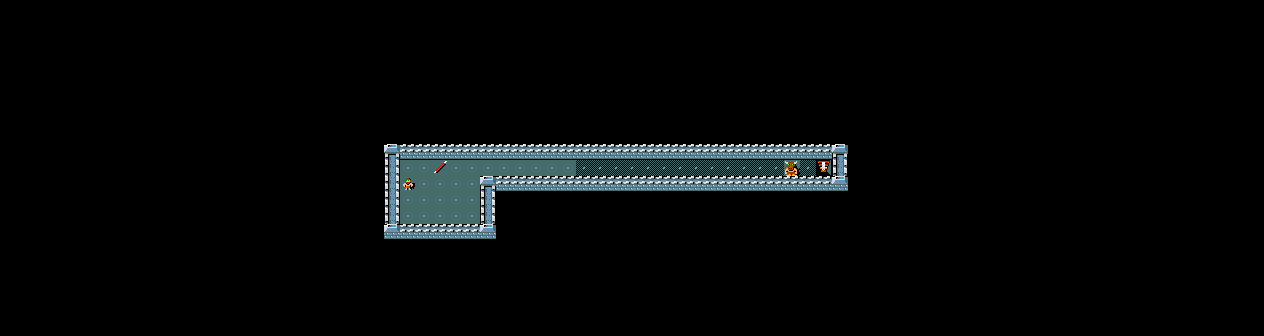

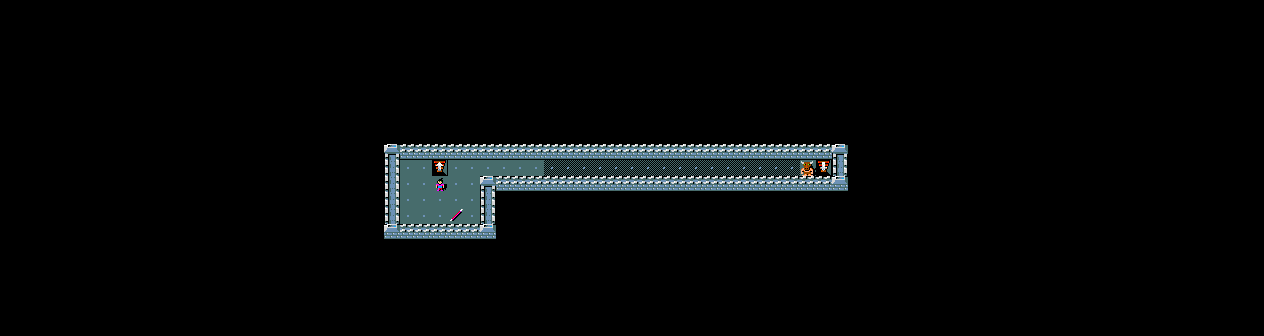

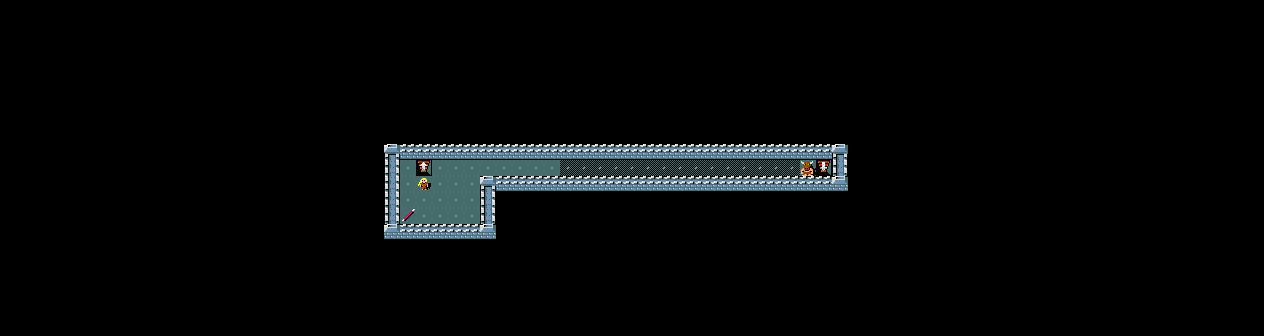

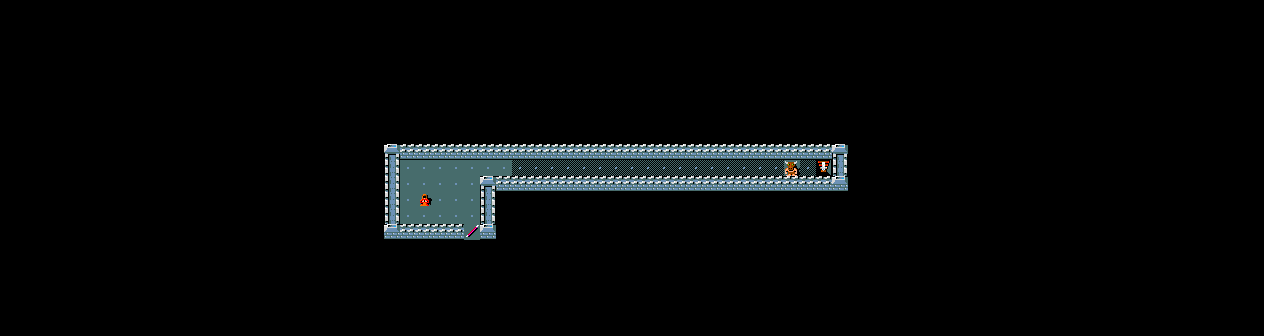

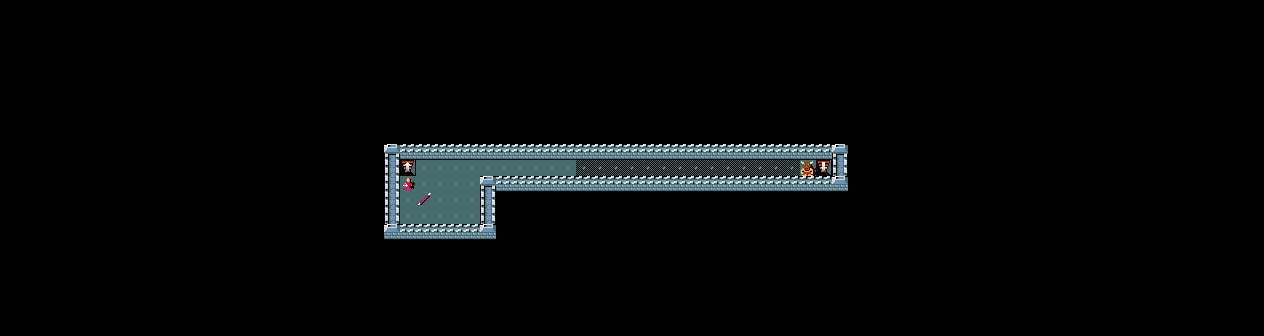

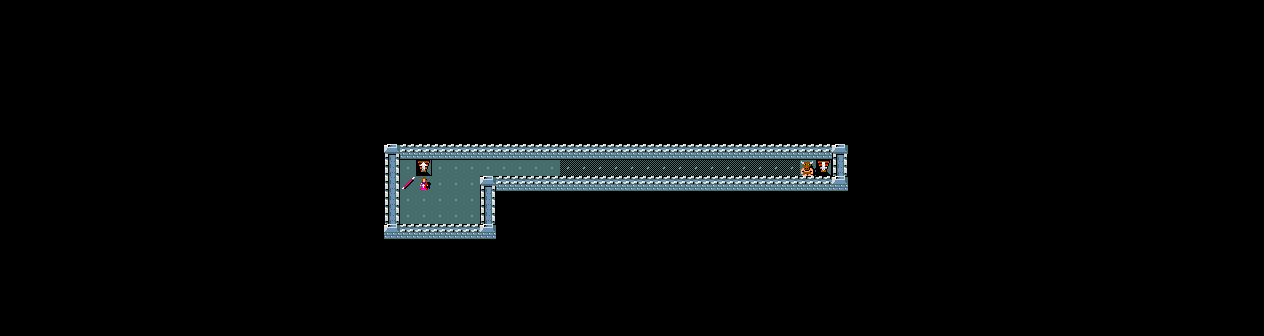

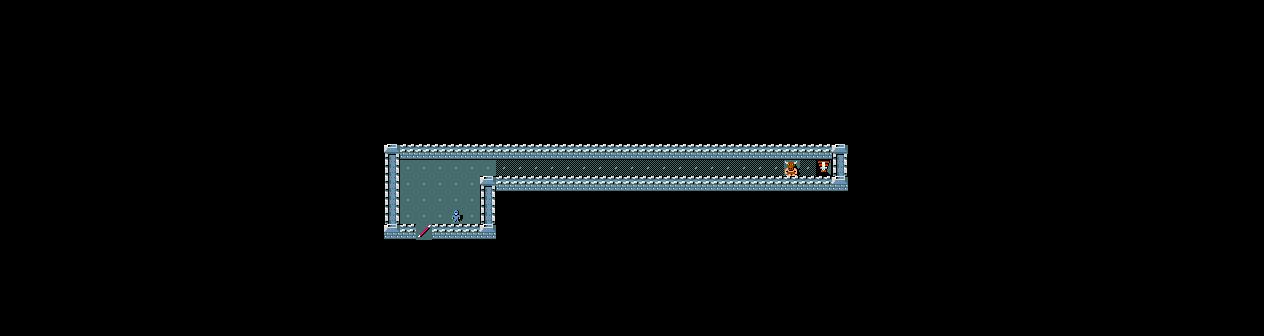

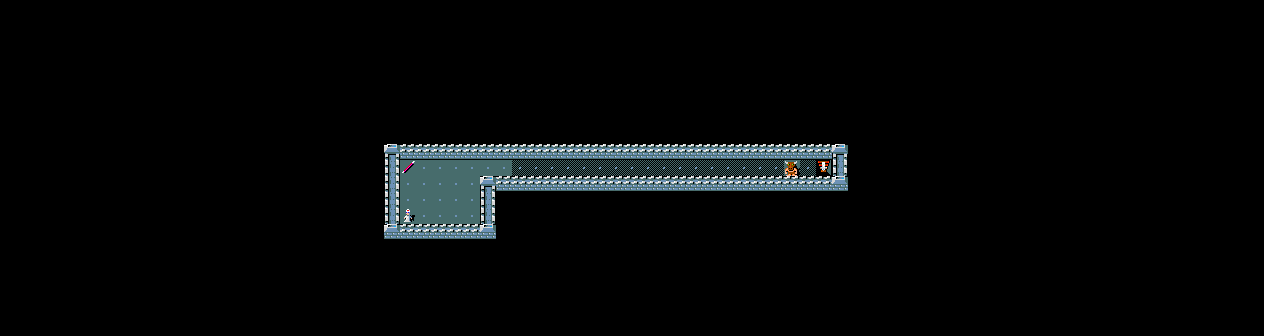

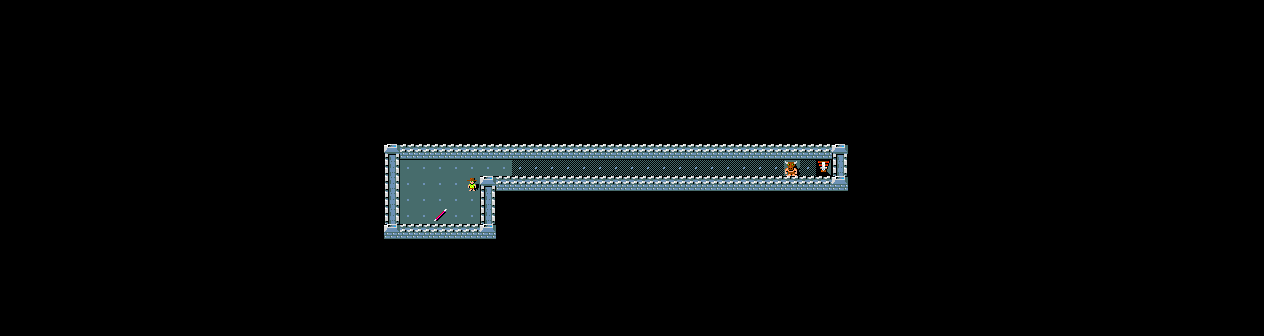

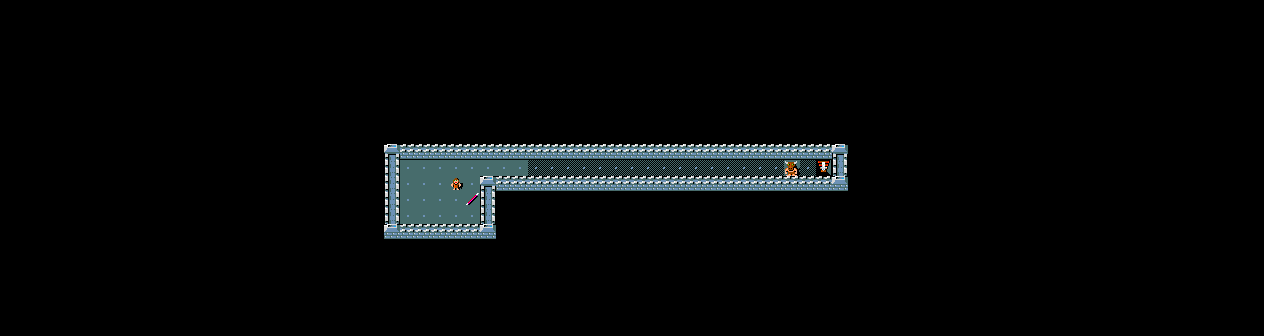

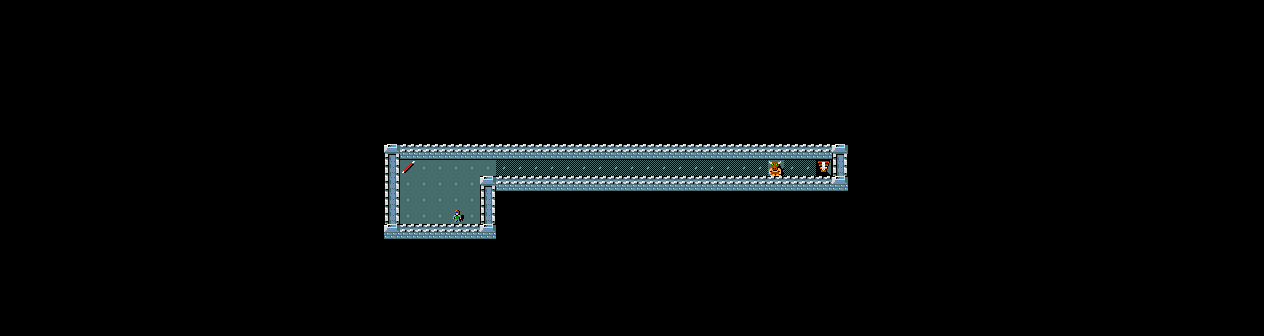

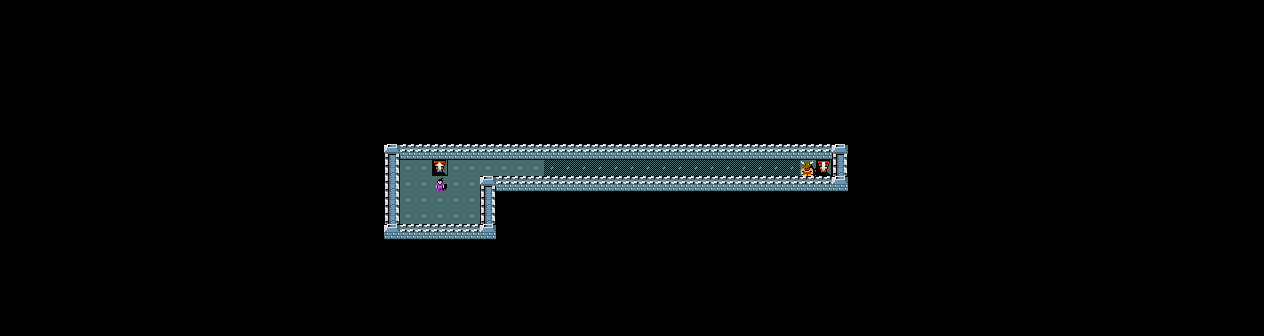

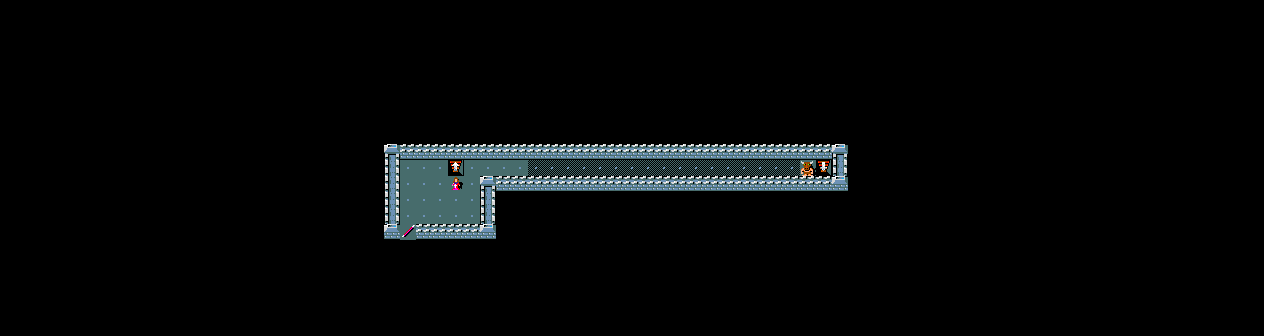

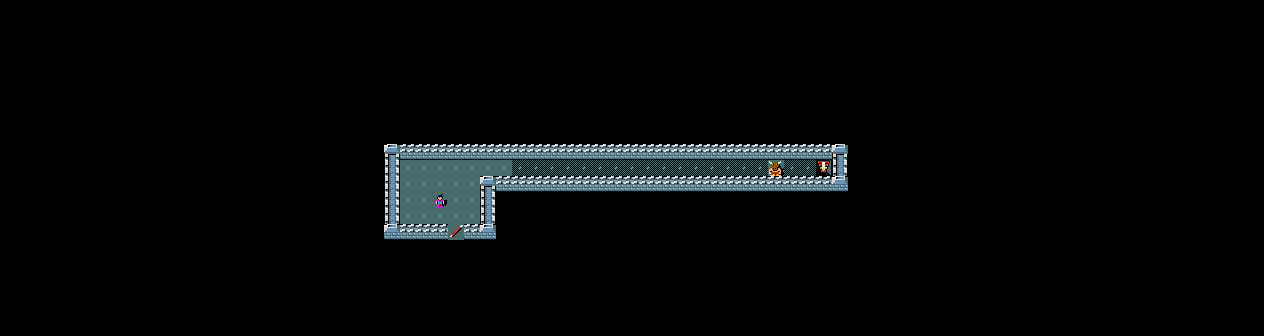

In [145]:
from nle.minihack.envs.skills_wod import MiniHackWoDHard as MH

def vislava(x):
    m = 8
    n= 33
    
    x = x[m*16:(m+5)*16,n*16:(n+10)*16,:]
    display(x)
    return x

for i in range(22):
    env = MH(savedir=None, archivefile=None,observation_keys=observation_keys,wizard=True)
    obs = env.reset()
    
    for c in "#wizintrinsic\rt\r\r":
        obs,sds = env.env.step(ord(c))
        
    for c in "#wizmap\r":
        obs,sds = env.env.step(ord(c))

    obs,_,_,_ =env.step(0)
    obs,_,_,_ =env.step(2)
    
    x = display(obs["pixel"],)
#     save(x, "keyroom", "keyroom_{}".format(i))